# San Francisco Crime Dataset Use Case.

 # . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### @author: Martín Blázquez Moreno

In [1]:
#Importing required packages
import re
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import HTML
import json

import sys
sys.path.insert(0,'..')
import folium
print (folium.__file__)
print (folium.__version__)
from matplotlib.colors import Normalize, rgb2hex

import pymongo
from pymongo import MongoClient, GEO2D

/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/folium/__init__.py
0.10.1


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

# First data exploration

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [2]:
# Data import from csv. Name: "San Francisco crime analysis"
total_crime = pd.read_csv('Map_of_Police_Department_Incidents.csv')
print("*************")
print(total_crime.shape)# To get the number of rows and columns
print("*************")
d_crime = total_crime.head(600000) # Only the firts 600000 are saved in 
    # d_crime to reduce the computation time.
d_crime# To see the DataFrame  with 600000 rows and 12 columns

*************
(2133457, 12)
*************


IncidntNum         Category  \
0        150060275     NON-CRIMINAL   
1        150098210          ROBBERY   
2        150098210          ASSAULT   
3        150098210  SECONDARY CODES   
4        150098226        VANDALISM   
...            ...              ...   
599995    76090005    LARCENY/THEFT   
599996    60887064         BURGLARY   
599997    60120422     NON-CRIMINAL   
599998   120681920        VANDALISM   
599999    40731356          RUNAWAY   

                                           Descript DayOfWeek  \
0                                     LOST PROPERTY    Monday   
1                             ROBBERY, BODILY FORCE    Sunday   
2              AGGRAVATED ASSAULT WITH BODILY FORCE    Sunday   
3                                 DOMESTIC VIOLENCE    Sunday   
4         MALICIOUS MISCHIEF, VANDALISM OF VEHICLES   Tuesday   
...                                             ...       ...   
599995                 GRAND THEFT FROM LOCKED AUTO  Thursday   
599996  BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY    Monday   
599997                                LOST PROPERTY   Tuesday   
599998         MALICIOUS MISCHIEF, BREAKING WINDOWS    Monday   
599999                                      RUNAWAY  Saturday   

                          Date   Time  PdDistrict Resolution  \
0       01/19/2015 12:00:00 AM  14:00     MISSION       NONE   
1       02/01/2015 12:00:00 AM  15:45  TENDERLOIN       NONE   
2       02/01/2015 12:00:00 AM  15:45  TENDERLOIN       NONE   
3       02/01/2015 12:00:00 AM  15:45  TENDERLOIN       NONE   
4       01/27/2015 12:00:00 AM  19:00    NORTHERN       NONE   
...                        ...    ...         ...        ...   
599995  12/06/2007 12:00:00 AM  08:35     MISSION       NONE   
599996  08/21/2006 12:00:00 AM  00:30     BAYVIEW       NONE   
599997  12/13/2005 12:00:00 AM  13:00     MISSION       NONE   
599998  08/27/2012 12:00:00 AM  00:15     CENTRAL       NONE   
599999  06/26/2004 12:00:00 AM  10:00     TARAVAL    LOCATED   

                            Address           X          Y  \
0             18TH ST / VALENCIA ST -122.421582  37.761701   
1       300 Block of LEAVENWORTH ST -122.414406  37.784191   
2       300 Block of LEAVENWORTH ST -122.414406  37.784191   
3       300 Block of LEAVENWORTH ST -122.414406  37.784191   
4            LOMBARD ST / LAGUNA ST -122.431119  37.800469   
...                             ...         ...        ...   
599995           14TH ST / MINNA ST -122.419227  37.768318   
599996       100 Block of DAKOTA ST -122.395635  37.753565   
599997         14TH ST / MISSION ST -122.419983  37.768273   
599998        500 Block of DAVIS ST -122.398448  37.798004   
599999      800 Block of CAPITOL AV -122.459007  37.717858   

                                     Location  
0        (37.7617007179518, -122.42158168137)  
1       (37.7841907151119, -122.414406029855)  
2       (37.7841907151119, -122.414406029855)  
3       (37.7841907151119, -122.414406029855)  
4       (37.8004687042875, -122.431118543788)  
...                                       ...  
599995  (37.7683179615007, -122.419226797663)  
599996  (37.7535645746594, -122.395635436168)  
599997  (37.7682726763664, -122.419983447705)  
599998  (37.7980037233355, -122.398447802857)  
599999   (37.717858450682, -122.459007287896)  

[600000 rows x 12 columns]

In [3]:
#Use a 40% of the datadase and delete de total_crime file because it is so big
seed = 4
d_crime=total_crime.sample(frac=0.40, random_state=seed)
del(total_crime)
d_crime


IncidntNum        Category                       Descript  DayOfWeek  \
1744847    96060470    NON-CRIMINAL                  LOST PROPERTY   Saturday   
85426     140247267        BURGLARY       BURGLARY, FORCIBLE ENTRY     Friday   
935450     41286245    NON-CRIMINAL                  LOST PROPERTY   Saturday   
1634002    30250639   LARCENY/THEFT     LOST PROPERTY, PETTY THEFT     Friday   
838544    110168176   LARCENY/THEFT        PETTY THEFT SHOPLIFTING   Saturday   
...             ...             ...                            ...        ...   
803101     51294846  OTHER OFFENSES   POSSESSION OF BURGLARY TOOLS  Wednesday   
442320     76009147   LARCENY/THEFT         GRAND THEFT PICKPOCKET   Saturday   
1046392    30491554       VANDALISM  MALICIOUS MISCHIEF, VANDALISM     Sunday   
1012511    80058091  OTHER OFFENSES                     CONSPIRACY   Thursday   
1284664    30108185   DRUG/NARCOTIC        POSSESSION OF MARIJUANA     Monday   

                           Date   Time  PdDistrict      Resolution  \
1744847  07/25/2009 12:00:00 AM  16:00     MISSION            NONE   
85426    03/21/2014 12:00:00 AM  19:00     CENTRAL            NONE   
935450   11/06/2004 12:00:00 AM  13:00    SOUTHERN            NONE   
1634002  02/28/2003 12:00:00 AM  23:30     BAYVIEW            NONE   
838544   02/26/2011 12:00:00 AM  12:00  TENDERLOIN   ARREST, CITED   
...                         ...    ...         ...             ...   
803101   11/16/2005 12:00:00 AM  10:30     BAYVIEW            NONE   
442320   02/03/2007 12:00:00 AM  00:30     CENTRAL            NONE   
1046392  04/27/2003 12:00:00 AM  01:55     MISSION  ARREST, BOOKED   
1012511  01/17/2008 12:00:00 AM  03:28        PARK   ARREST, CITED   
1284664  01/27/2003 12:00:00 AM  12:49  TENDERLOIN   ARREST, CITED   

                           Address           X          Y  \
1744847      22ND ST / BARTLETT ST -122.419861  37.755367   
85426       200 Block of KEARNY ST -122.403956  37.790049   
935450         MISSION ST / 3RD ST -122.402028  37.786248   
1634002  1700 Block of YOSEMITE AV -122.394542  37.728421   
838544      0 Block of OFARRELL ST -122.405895  37.786734   
...                            ...         ...        ...   
803101     1100 Block of SILVER AV -122.413573  37.729719   
442320       600 Block of GEARY ST -122.413989  37.786569   
1046392     400 Block of CASTRO ST -122.435012  37.761768   
1012511    1200 Block of FULTON ST -122.437369  37.777014   
1284664        0 Block of JONES ST -122.412193  37.781605   

                                      Location  
1744847  (37.7553668828503, -122.419860961947)  
85426    (37.7900489356744, -122.403956301191)  
935450     (37.78624834564, -122.402027706956)  
1634002   (37.7284206717765, -122.39454192298)  
838544   (37.7867342184983, -122.405895369887)  
...                                        ...  
803101   (37.7297190859367, -122.413572755764)  
442320   (37.7865685406761, -122.413988841812)  
1046392  (37.7617677182954, -122.435012093789)  
1012511  (37.7770141887437, -122.437369096387)  
1284664  (37.7816045741252, -122.412192555721)  

[853383 rows x 12 columns]

In [4]:
#type of each of the fields
d_crime.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
dtype: object

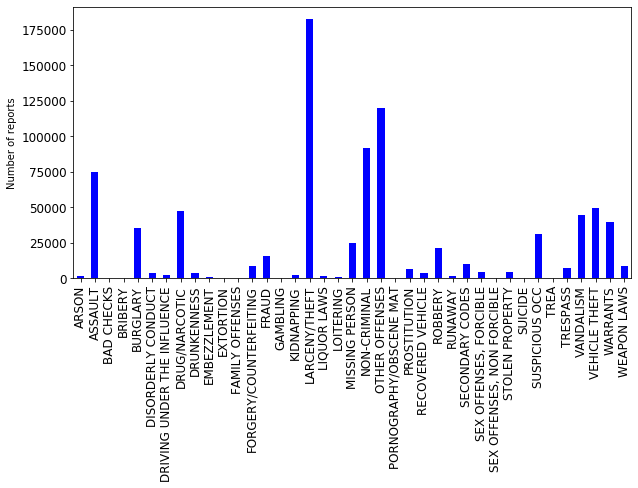

In [5]:
#To count all type of categories
d_crime['Category'].value_counts()

def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='b')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)
    
plotdat(d_crime,'Category')

In [6]:
# Data cleaning. Transform Data from string to date type and delta date
date=pd.to_datetime(d_crime['Date'])
print(date.min())
print(date.max())

2003-01-01 00:00:00
2017-10-15 00:00:00


In [7]:
# Create a new colum "days" with timedelta format
t_delta=(date-date.min()).astype('timedelta64[D]')
d_crime['days']=t_delta
d_crime.head(1)

IncidntNum      Category       Descript DayOfWeek  \
1744847    96060470  NON-CRIMINAL  LOST PROPERTY  Saturday   

                           Date   Time PdDistrict Resolution  \
1744847  07/25/2009 12:00:00 AM  16:00    MISSION       NONE   

                       Address           X          Y  \
1744847  22ND ST / BARTLETT ST -122.419861  37.755367   

                                      Location    days  
1744847  (37.7553668828503, -122.419860961947)  2397.0

## Analyse the columns of the DataBase

In [8]:
# Plotting bargraph. Define again.
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='blue')
    plt.xlabel('Type')
    plt.ylabel('Number of reports',fontsize=10)

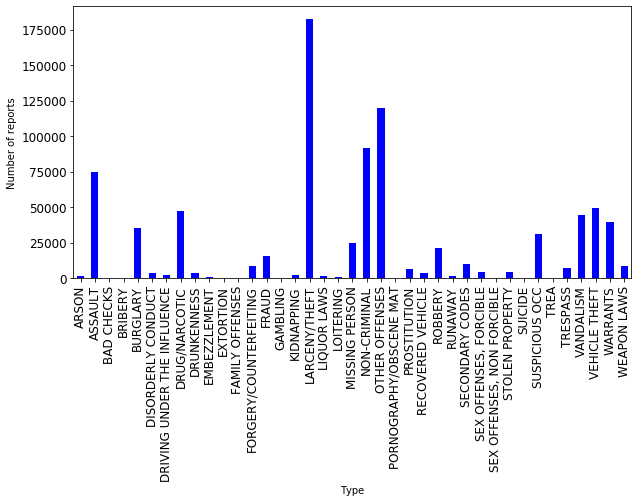

In [9]:
# Graph of the incident type and amount occurred
plotdat(d_crime,'Category')

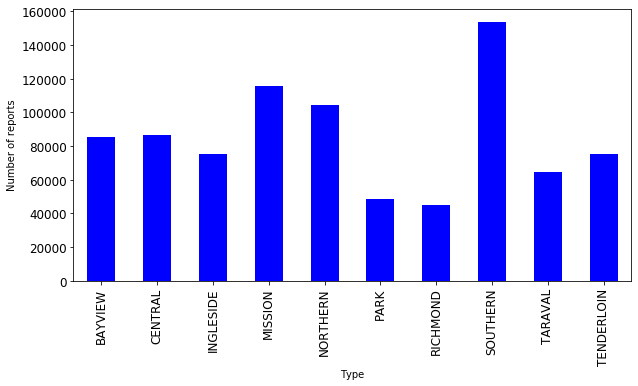

In [10]:
# Graph of the different district where the incidents occur
plotdat(d_crime,'PdDistrict')

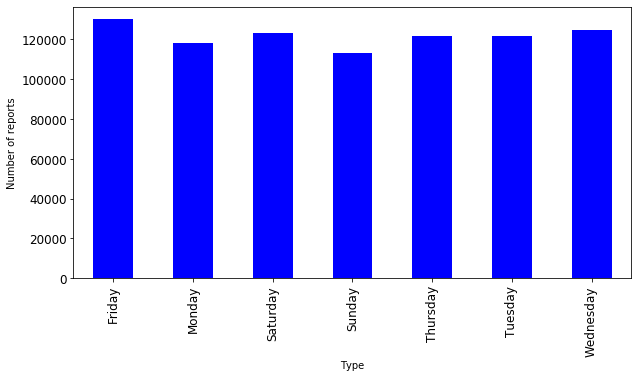

In [11]:
# Graph with the Day of the week when the incident occur.
plotdat(d_crime,'DayOfWeek')

The week day is not a significant variable in terms of number of cases reported.

In [12]:
#The greater number of cases with the same description.
l=d_crime.groupby('Descript').size()
l.sort_values()
print(l.shape)

(882,)


In [13]:
# Heatmap and hierarchical clustering
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [14]:
t=types_districts(d_crime,98)

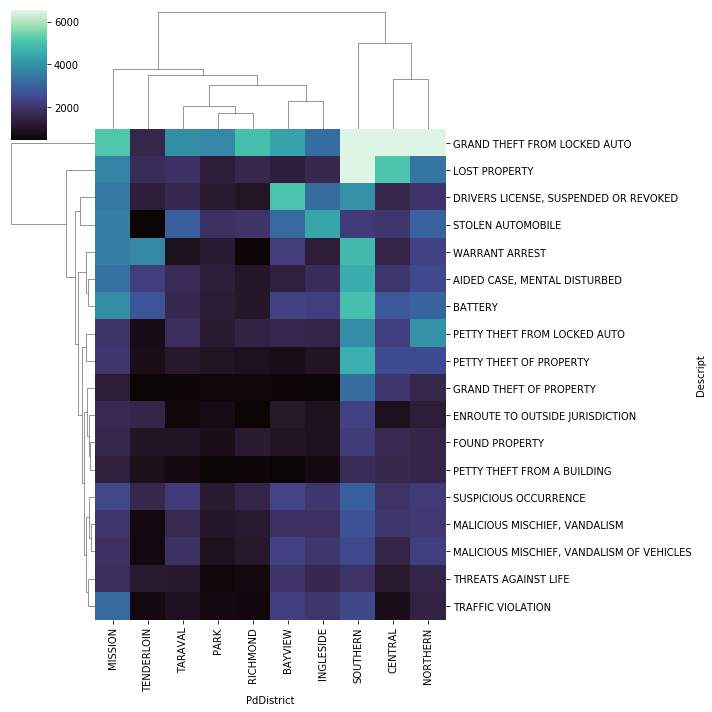

In [15]:
sns.clustermap(t,cmap="mako", robust=True) 

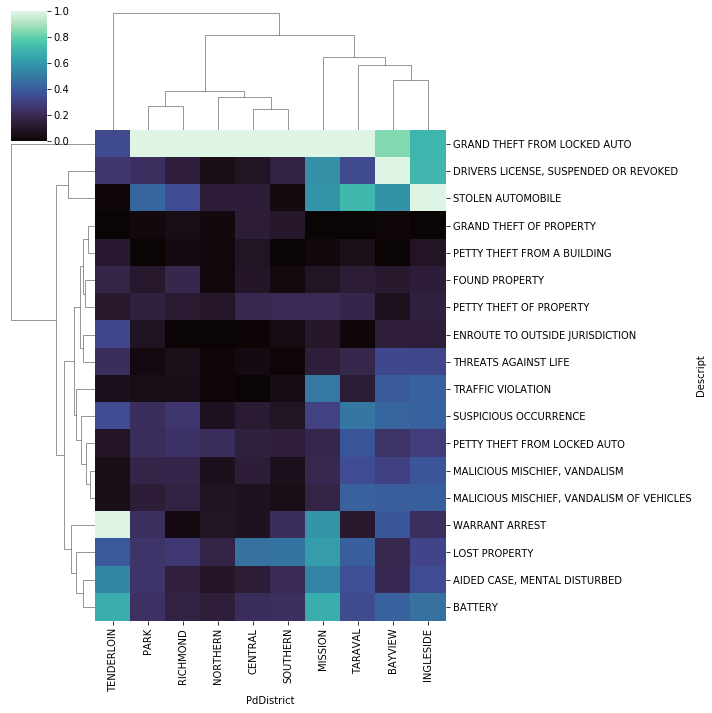

In [16]:
# It is required to scale dimensions
# Standardize the data within the columns (scale=1)
# Sometimes, a few values in your input have extreme values. 
# In a heatmap, this has as an effect to make every other cell the same color, what is not desired. 
# The clustermap function allows you to avoid that with the ‘robust‘ argument. Here is an example with (left) and without (right) this option.

sns.clustermap(t,standard_scale=1,cmap="mako", robust=True)

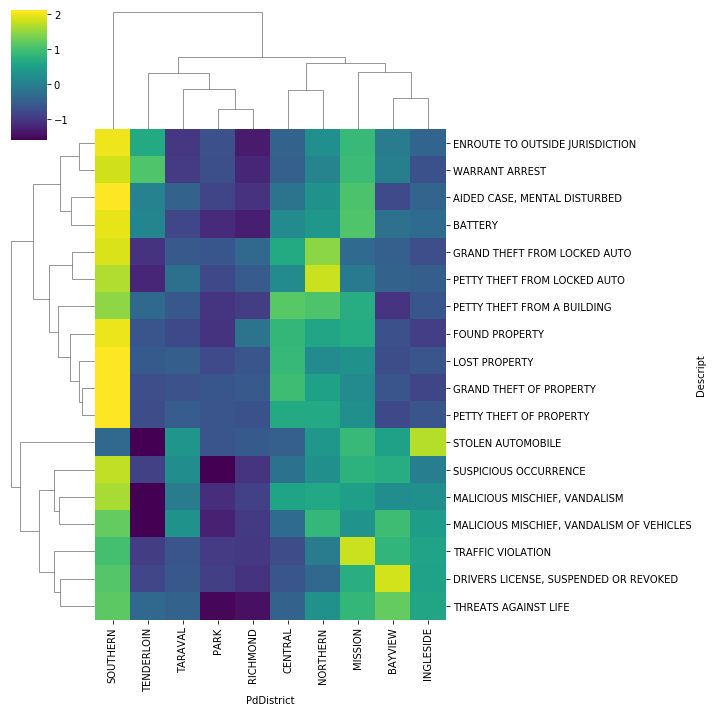

In [17]:
# Normalize the data within the rows s_score=0
sns.clustermap(t,z_score=0,cmap="viridis", robust=True)

# . . . . . . . . . . . . . . . . . . . . . . . . . 

## Let's drill down onto the Mandatory Task

# . . . . . . . . . . . . . . . . . . . . . . . . . 

#### Mongo Database connection and store data______________________________________________________________________________

In [18]:
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.test
collection = db.crimesf

Mongo version 3.9.0


In [19]:
#Clean collection 
collection.drop()

In [20]:
#Import data into the database. First, transform to JSON records
records = json.loads(d_crime.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [21]:
#Check if I can access the data from the MongoDB.
cursor = collection.find().sort('Category',pymongo.ASCENDING).limit(5)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e8b0e51072ad8792d0861da'), 'IncidntNum': 120897343, 'Category': 'ARSON', 'Descript': 'ARSON OF A VEHICLE', 'DayOfWeek': 'Tuesday', 'Date': '11/06/2012 12:00:00 AM', 'Time': '02:23', 'PdDistrict': 'BAYVIEW', 'Resolution': 'NONE', 'Address': '1500 Block of KEITH ST', 'X': -122.3875096237, 'Y': 37.7315705608, 'Location': '(37.7315705607957, -122.387509623742)', 'days': 3597.0}
{'_id': ObjectId('5e8b0e51072ad8792d0861e7'), 'IncidntNum': 70738899, 'Category': 'ARSON', 'Descript': 'ARSON OF A VACANT BUILDING', 'DayOfWeek': 'Sunday', 'Date': '07/22/2007 12:00:00 AM', 'Time': '07:35', 'PdDistrict': 'BAYVIEW', 'Resolution': 'NONE', 'Address': '0 Block of HARBOR RD', 'X': -122.3783922575, 'Y': 37.7323312464, 'Location': '(37.7323312464378, -122.378392257534)', 'days': 1663.0}
{'_id': ObjectId('5e8b0e51072ad8792d08637d'), 'IncidntNum': 160352614, 'Category': 'ARSON', 'Descript': 'ARSON OF A VEHICLE', 'DayOfWeek': 'Saturday', 'Date': '04/30/2016 12:00:00 AM', 'Time': '03:15', 'P

In [22]:
#########################################################################
#T here are many categories but the analysis will be focus in VANDALISM.#
#########################################################################

#stablish a pipeline to select all rows matching attribute "Category" = "VANDALISM"
pipeline = [
        {"$match": {"Category":"VANDALISM"}},
]

In [23]:
#We will be count the number of rows that has the category VANDALISM in our 40% data set. 
collection.count_documents({"Category":"VANDALISM"})

44431

In [24]:
#Query the collection with the pipeline filter. 
aggResult = collection.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))
df2.head()

_id  IncidntNum   Category  \
0  5e8b0e51072ad8792d085cb4   120432648  VANDALISM   
1  5e8b0e51072ad8792d085cb7    60687864  VANDALISM   
2  5e8b0e51072ad8792d085cbd    76028313  VANDALISM   
3  5e8b0e51072ad8792d085cc7   130171466  VANDALISM   
4  5e8b0e51072ad8792d085cd0   120100146  VANDALISM   

                                    Descript DayOfWeek  \
0  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES  Thursday   
1  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    Monday   
2              MALICIOUS MISCHIEF, VANDALISM  Saturday   
3  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES  Thursday   
4          MALICIOUS MISCHIEF, TIRE SLASHING    Friday   

                     Date   Time PdDistrict Resolution  \
0  05/31/2012 12:00:00 AM  21:27    BAYVIEW       NONE   
1  06/12/2006 12:00:00 AM  21:00   NORTHERN       NONE   
2  04/28/2007 12:00:00 AM  17:45   SOUTHERN       NONE   
3  02/28/2013 12:00:00 AM  04:30       PARK       NONE   
4  02/03/2012 12:00:00 AM  19:00  INGLESIDE       NONE   

                               Address           X          Y  \
0              200 Block of WOOLSEY ST -122.404081  37.724792   
1          3200 Block of DIVISADERO ST -122.442817  37.799490   
2  FOLSOM ST / THE EMBARCADEROSOUTH ST -122.390094  37.790764   
3              1100 Block of FULTON ST -122.435712  37.777227   
4              200 Block of CHENERY ST -122.426931  37.737789   

                                Location    days  
0  (37.7247922214353, -122.404081439853)  3438.0  
1    (37.7994896740468, -122.4428172375)  1258.0  
2  (37.7907638589303, -122.390094248247)  1578.0  
3  (37.7772265479422, -122.435712397837)  3711.0  
4  (37.7377893527232, -122.426931311652)  3320.0

In [25]:
# Let's have a look on Vandalism incidents' descriptions from greater amount to smaller amount
c=df2['Descript'].value_counts()
c.sort_values(ascending=False)
c.head(25)

MALICIOUS MISCHIEF, VANDALISM                               17046
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES                   17020
MALICIOUS MISCHIEF, BREAKING WINDOWS                         4753
MALICIOUS MISCHIEF, GRAFFITI                                 3372
MALICIOUS MISCHIEF                                            411
MALICIOUS MISCHIEF, TIRE SLASHING                             334
MALICIOUS MISCHIEF, STREET CARS/BUSES                         302
MALICIOUS MISCHIEF, ADULT SUSPECT                             280
VANDALISM OR GRAFFITI TOOLS, POSSESSION                       261
MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN              215
MALICIOUS MISCHIEF, JUVENILE SUSPECT                           88
VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY           71
GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION       63
MALICIOUS MISCHIEF, FICTITIOUS PHONE CALLS                     44
MALICIOUS MISCHIEF, BUILDING UNDER CONSTRUCTION                43
DAMAGE TO 

In [26]:
# Organize incidents' descriptions versus Districts where they were detected
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [27]:
# Filter outliers up to 65 percentile to analyze just the vandalism type with more incidents, the rest are irrelevant
t=types_districts(df2,70)

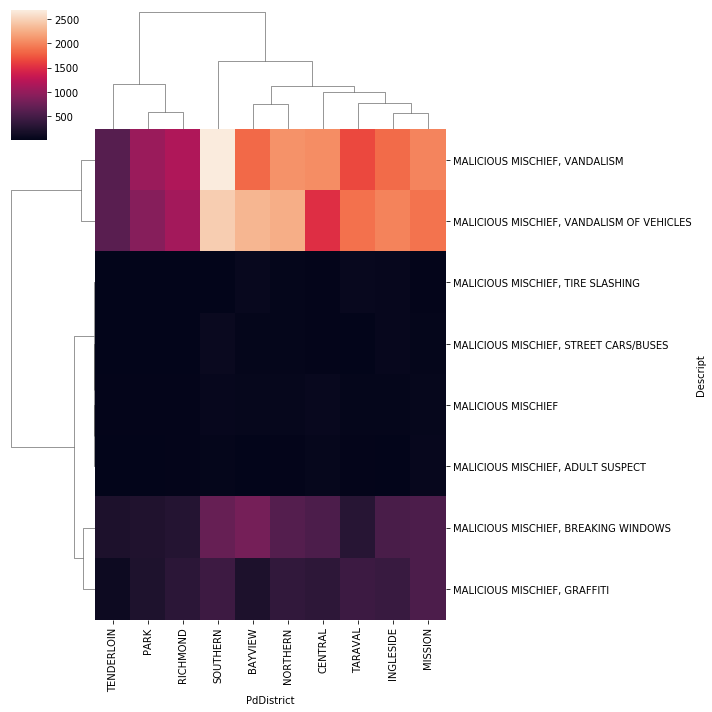

In [28]:
# Inspect data by means of clustermaps
sns.clustermap(t)

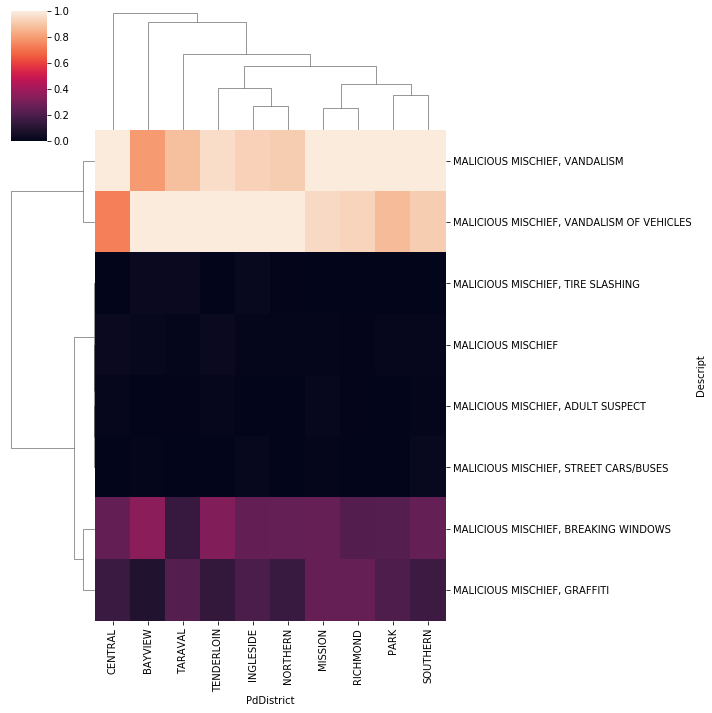

In [29]:
sns.clustermap(t,standard_scale=1)

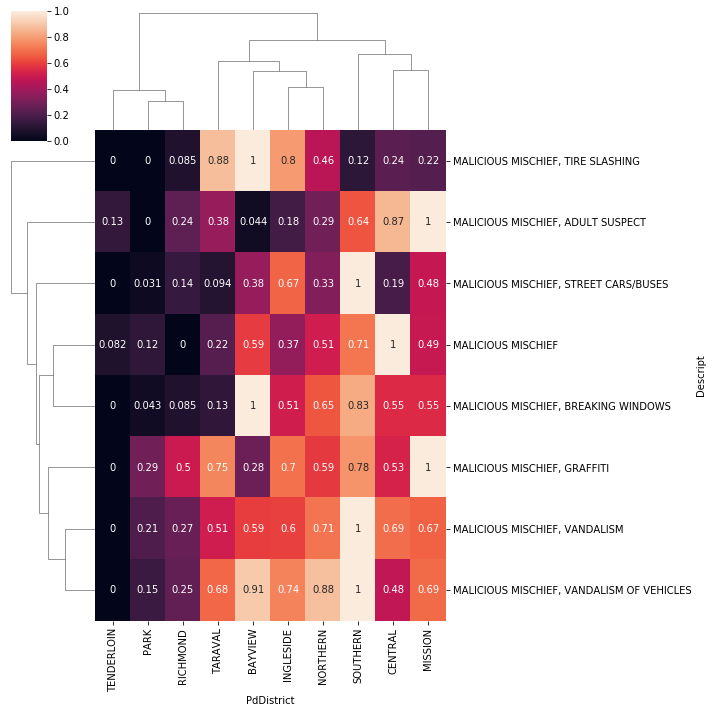

In [30]:
sns.clustermap(t,standard_scale=0, annot=True)

# . . . . . . . . . . . . . . . . . 

## Time Series Analysis

# . . . . . . . . . . . . . . . . .

In [31]:
# Bin crime by 30 day window. That is, obtain new colum with corresponding months 
df2['Month']=np.floor(df2['days']/30) # Approximate month (30 day window)

In [32]:
# Default
district='All'

In [33]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
  
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    
    return t

In [34]:
# Filter outliers up to 10 percentile
t_all=timeseries(df2,10)

In [35]:
#Find inciden's descriptions related to word patter "MALICIOUS"
pat = re.compile(r'MALICIOUS', re.I)

In [36]:
pipeline = [
        {"$match": {"Category":"VANDALISM" , 'Descript': {'$regex': pat}}},
]

In [37]:
aggResult = collection.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))
df3.head()

_id  IncidntNum   Category  \
0  5e8b0e51072ad8792d085cb4   120432648  VANDALISM   
1  5e8b0e51072ad8792d085cb7    60687864  VANDALISM   
2  5e8b0e51072ad8792d085cbd    76028313  VANDALISM   
3  5e8b0e51072ad8792d085cc7   130171466  VANDALISM   
4  5e8b0e51072ad8792d085cd0   120100146  VANDALISM   

                                    Descript DayOfWeek  \
0  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES  Thursday   
1  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    Monday   
2              MALICIOUS MISCHIEF, VANDALISM  Saturday   
3  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES  Thursday   
4          MALICIOUS MISCHIEF, TIRE SLASHING    Friday   

                     Date   Time PdDistrict Resolution  \
0  05/31/2012 12:00:00 AM  21:27    BAYVIEW       NONE   
1  06/12/2006 12:00:00 AM  21:00   NORTHERN       NONE   
2  04/28/2007 12:00:00 AM  17:45   SOUTHERN       NONE   
3  02/28/2013 12:00:00 AM  04:30       PARK       NONE   
4  02/03/2012 12:00:00 AM  19:00  INGLESIDE       NONE   

                               Address           X          Y  \
0              200 Block of WOOLSEY ST -122.404081  37.724792   
1          3200 Block of DIVISADERO ST -122.442817  37.799490   
2  FOLSOM ST / THE EMBARCADEROSOUTH ST -122.390094  37.790764   
3              1100 Block of FULTON ST -122.435712  37.777227   
4              200 Block of CHENERY ST -122.426931  37.737789   

                                Location    days  
0  (37.7247922214353, -122.404081439853)  3438.0  
1    (37.7994896740468, -122.4428172375)  1258.0  
2  (37.7907638589303, -122.390094248247)  1578.0  
3  (37.7772265479422, -122.435712397837)  3711.0  
4  (37.7377893527232, -122.426931311652)  3320.0

In [38]:
malicious = df3.groupby('Descript').size()
s = pd.Series(malicious)

In [39]:
print(s)

Descript
MALICIOUS MISCHIEF                                    411
MALICIOUS MISCHIEF, ADULT SUSPECT                     280
MALICIOUS MISCHIEF, BREAKING WINDOWS                 4753
MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN      215
MALICIOUS MISCHIEF, BUILDING UNDER CONSTRUCTION        43
MALICIOUS MISCHIEF, FICTITIOUS PHONE CALLS             44
MALICIOUS MISCHIEF, GRAFFITI                         3372
MALICIOUS MISCHIEF, JUVENILE SUSPECT                   88
MALICIOUS MISCHIEF, STREET CARS/BUSES                 302
MALICIOUS MISCHIEF, TIRE SLASHING                     334
MALICIOUS MISCHIEF, VANDALISM                       17046
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES           17020
dtype: int64


In [40]:
s = s[s != 1]

In [41]:
malicious_features = list(s.index)

In [42]:
print(malicious_features)

['MALICIOUS MISCHIEF', 'MALICIOUS MISCHIEF, ADULT SUSPECT', 'MALICIOUS MISCHIEF, BREAKING WINDOWS', 'MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN', 'MALICIOUS MISCHIEF, BUILDING UNDER CONSTRUCTION', 'MALICIOUS MISCHIEF, FICTITIOUS PHONE CALLS', 'MALICIOUS MISCHIEF, GRAFFITI', 'MALICIOUS MISCHIEF, JUVENILE SUSPECT', 'MALICIOUS MISCHIEF, STREET CARS/BUSES', 'MALICIOUS MISCHIEF, TIRE SLASHING', 'MALICIOUS MISCHIEF, VANDALISM', 'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES']


In [43]:
#Let's generate a function to constructu subsets of descriptions according to patterns: 
def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
   
    pipeline = [
            {"$match": {"Category":"VANDALISM" , 'Descript': {'$regex': pat}}},
    ]
    
    aggResult = collection.aggregate(pipeline)
    df3 = pd.DataFrame(list(aggResult))
    vandalism = df3.groupby('Descript').size()
    s = pd.Series(vandalism)
    s = s[s != 1] # filter those descriptions with value less equal 1
    features = list(s.index)
    
    return features

In [44]:
# Filter by pattern 'VEHICLES'
graffiti_features = descriptionsAccordingToPattern('GRAFFITI')

In [45]:
print(graffiti_features)

['GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION', 'MALICIOUS MISCHIEF, GRAFFITI', 'VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY', 'VANDALISM OR GRAFFITI TOOLS, POSSESSION']


In [46]:
suspect_features = descriptionsAccordingToPattern('ADULT SUSPECT')
break_features = descriptionsAccordingToPattern('BREAKING WINDOWS')
gun_features = descriptionsAccordingToPattern('BREAKING WINDOWS WITH BB GUN')
build_features = descriptionsAccordingToPattern('BUILDING UNDER CONSTRUCTION')
calls_features = descriptionsAccordingToPattern('FICTITIOUS PHONE CALLS')
graf_features = descriptionsAccordingToPattern('GRAFFITI')
juvenile_features = descriptionsAccordingToPattern('JUVENILE SUSPECT')
street_features = descriptionsAccordingToPattern('STREET CARS/BUSES')
tire_features = descriptionsAccordingToPattern('TIRE SLASHING')
vandalism_features = descriptionsAccordingToPattern('VANDALISM')
vehicles_features = descriptionsAccordingToPattern('VANDALISM OF VEHICLES')

In [47]:
# Lets use real dates for plotting
days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

In [48]:
# Analytics per vandalism tipology according to descriptions
def vandalism_analysis(t,district,plot):
    t['ADULT SUSPECT']=t[suspect_features].sum(axis=1)
    t['BREAKING WINDOWS']=t[break_features].sum(axis=1)
    t['BREAKING WINDOWS WITH BB GUN']=t[gun_features].sum(axis=1)
    t['BUILDING UNDER CONSTRUCTION']=t[build_features].sum(axis=1)
    t['FICTITIOUS PHONE CALLS']=t[calls_features].sum(axis=1)
    t['GRAFFITI']=t[graf_features].sum(axis=1)
    t['JUVENILE SUSPECT']=t[juvenile_features].sum(axis=1)
    t['STREET CARS/BUSES']=t[street_features].sum(axis=1)
    t['TIRE SLASHING']=t[tire_features].sum(axis=1)
    t['VANDALISM']=t[vandalism_features].sum(axis=1)
    t['VANDALISM OF VEHICLES']=t[vehicles_features].sum(axis=1)
    
    vandalism=t[['ADULT SUSPECT','BREAKING WINDOWS','BREAKING WINDOWS WITH BB GUN','BUILDING UNDER CONSTRUCTION','FICTITIOUS PHONE CALLS','GRAFFITI','JUVENILE SUSPECT','STREET CARS/BUSES','TIRE SLASHING','VANDALISM','VANDALISM OF VEHICLES']]
    if plot:
        vandalism.index=[int(i) for i in vandalism.index]
        colors = plt.cm.jet(np.linspace(0, 1, vandalism.shape[1]))
        vandalism.plot(kind='bar', stacked=True, figsize=(20,10), color=colors, width=1, title=district,fontsize=6)
    return vandalism

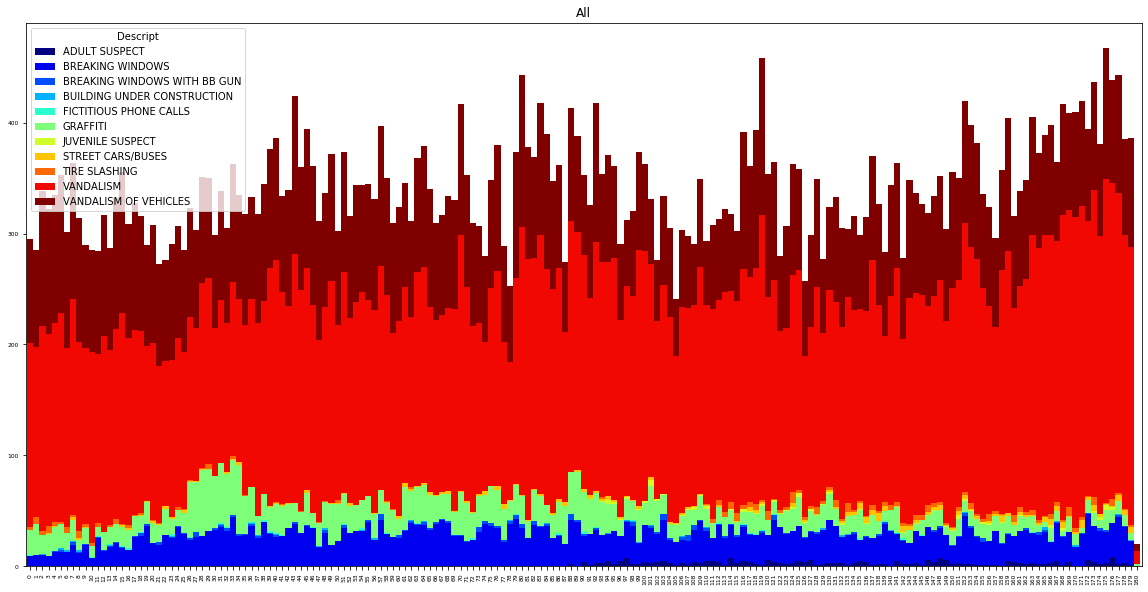

In [49]:
vanda_df_all=vandalism_analysis(t_all,district,True)

In [50]:
def vandalism_analysis_rescale(t,district,plot):
    t['ADULT SUSPECT']=t[suspect_features].sum(axis=1)
    t['BREAKING WINDOWS']=t[break_features].sum(axis=1)
    t['BREAKING WINDOWS WITH BB GUN']=t[gun_features].sum(axis=1)
    t['BUILDING UNDER CONSTRUCTION']=t[build_features].sum(axis=1)
    t['FICTITIOUS PHONE CALLS']=t[calls_features].sum(axis=1)
    t['GRAFFITI']=t[graf_features].sum(axis=1)
    t['JUVENILE SUSPECT']=t[juvenile_features].sum(axis=1)
    t['STREET CARS/BUSES']=t[street_features].sum(axis=1)
    t['TIRE SLASHING']=t[tire_features].sum(axis=1)
    t['VANDALISM']=t[vandalism_features].sum(axis=1)
    t['VANDALISM OF VEHICLES']=t[vehicles_features].sum(axis=1)

    vandalism=t[['ADULT SUSPECT','BREAKING WINDOWS','BREAKING WINDOWS WITH BB GUN','BUILDING UNDER CONSTRUCTION','FICTITIOUS PHONE CALLS','GRAFFITI','JUVENILE SUSPECT','STREET CARS/BUSES','TIRE SLASHING','VANDALISM','VANDALISM OF VEHICLES']]
    if plot:
        vandalism=vandalism.div(vandalism.sum(axis=1),axis=0)
        vandalism.index=[int(i) for i in vandalism.index]
        colors = plt.cm.GnBu(np.linspace(0, 1, vandalism.shape[1]))
        colors = plt.cm.jet(np.linspace(0, 1, vandalism.shape[1]))
        vandalism.plot(kind='bar', stacked=True, figsize=(20,10), color=colors, width=1, title=district, legend=True)
        plt.ylim([0,1])
    return vandalism

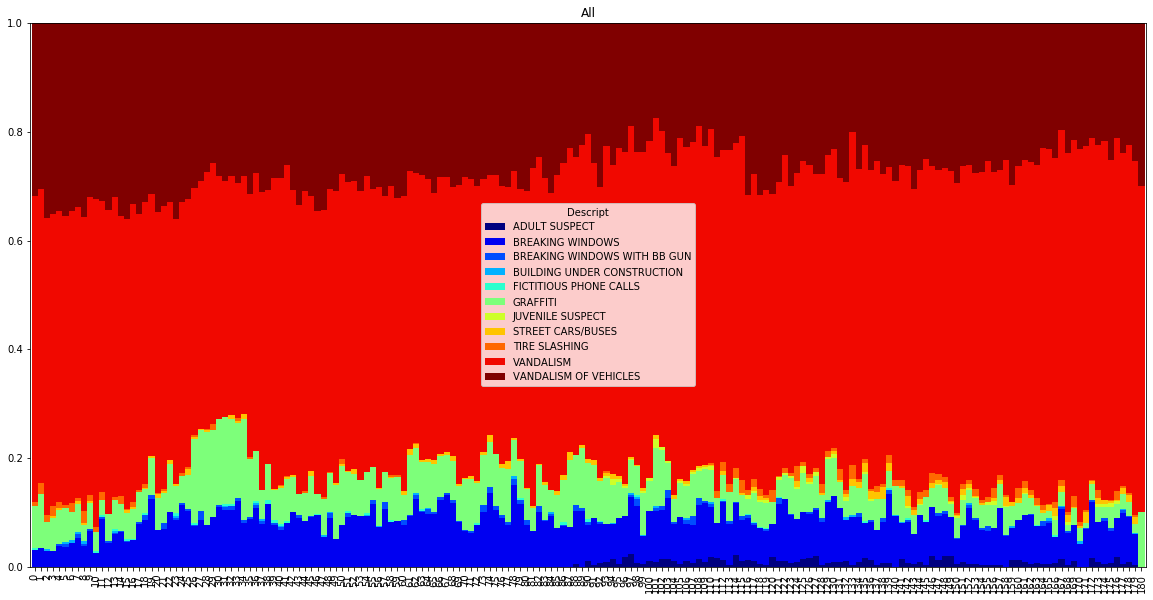

In [51]:
vanda_df_all=vandalism_analysis_rescale(t_all,district,True)

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

# Focussing on real dates and Districts

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### Let's add the real dates.
#### And focusing on several types of vandalism

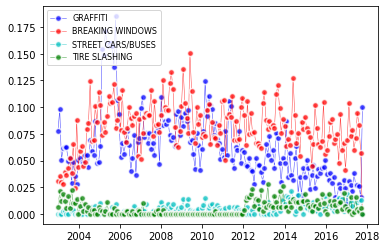

In [52]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['GRAFFITI','BREAKING WINDOWS','STREET CARS/BUSES','TIRE SLASHING'],['b','r','c','g']):
    plt.plot(dates_for_plot.index,vanda_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

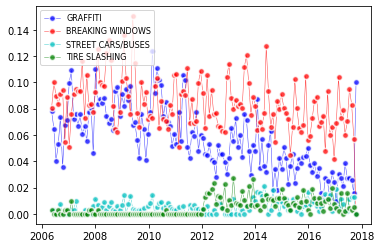

In [53]:
# filter in 2006 because there are outlier between 2005 and 2006
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (10,1)})
for d,c in zip(['GRAFFITI','BREAKING WINDOWS','STREET CARS/BUSES','TIRE SLASHING'],['b','r','c','g']):
    plt.plot(dates_for_plot.tail(140).index,vanda_df_all[d].tail(140),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

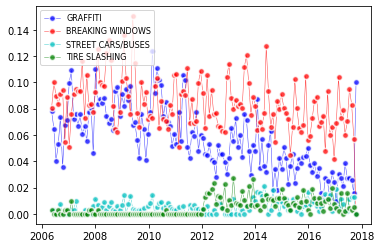

In [54]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (5,5)})
for d,c in zip(['GRAFFITI','BREAKING WINDOWS','STREET CARS/BUSES','TIRE SLASHING'],['b','r','c','g']):
    plt.plot(dates_for_plot.tail(140).index,vanda_df_all[d].tail(140),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


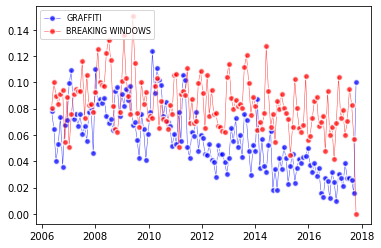

In [55]:
# Remove 'TIRE SLASHING' and  'STREET CARS/BUSES' as it has different range
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['GRAFFITI','BREAKING WINDOWS'],['b','r']):
    plt.plot(dates_for_plot.tail(140).index,vanda_df_all[d].tail(140),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


### To see more in depth, iterate through each district.

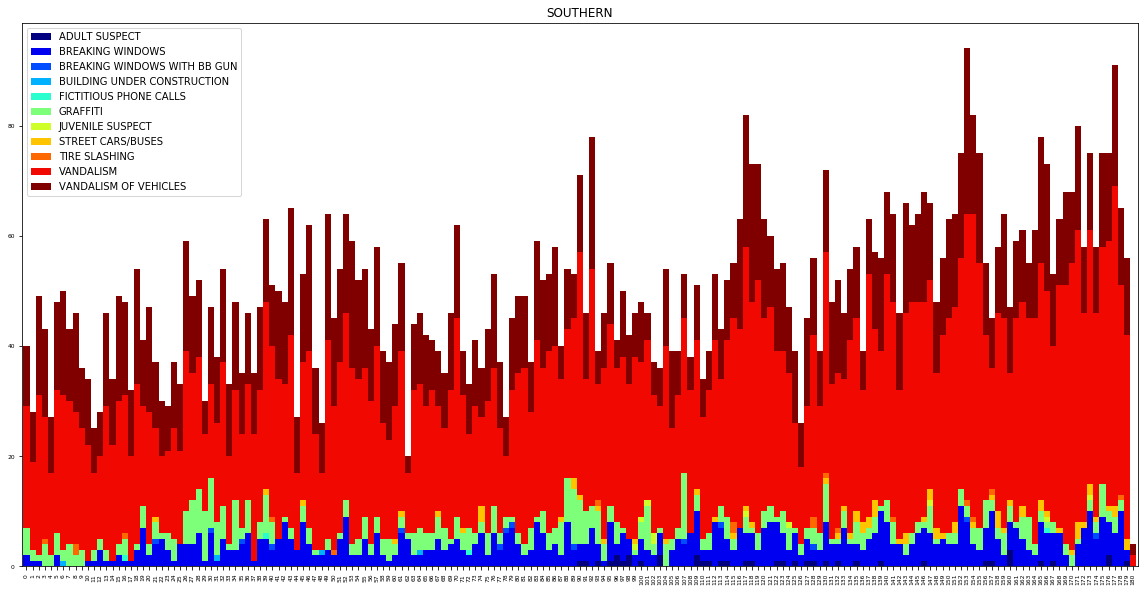

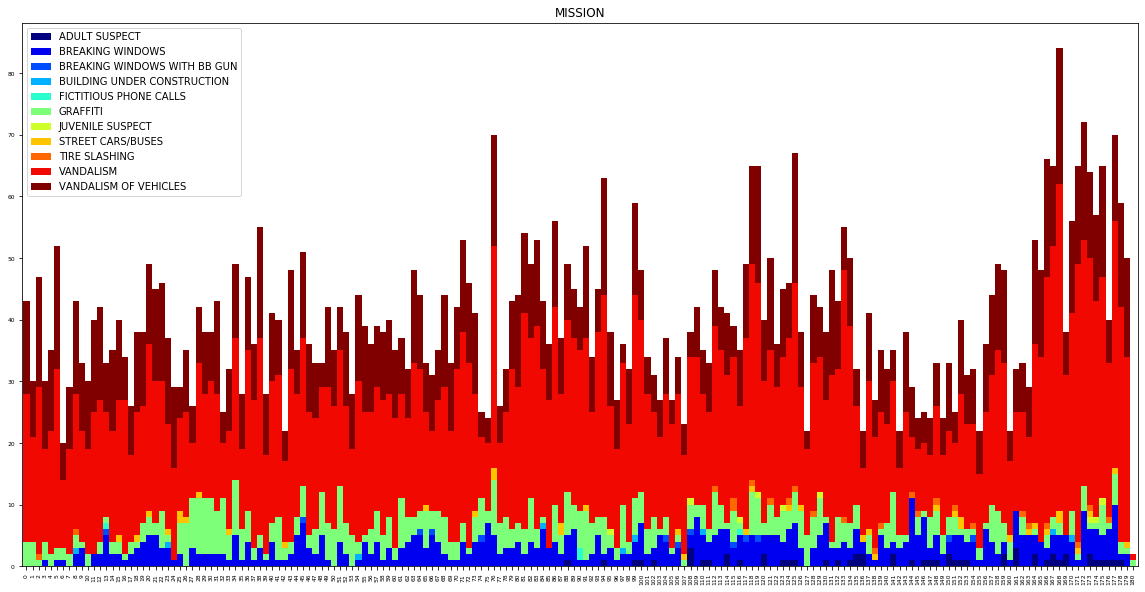

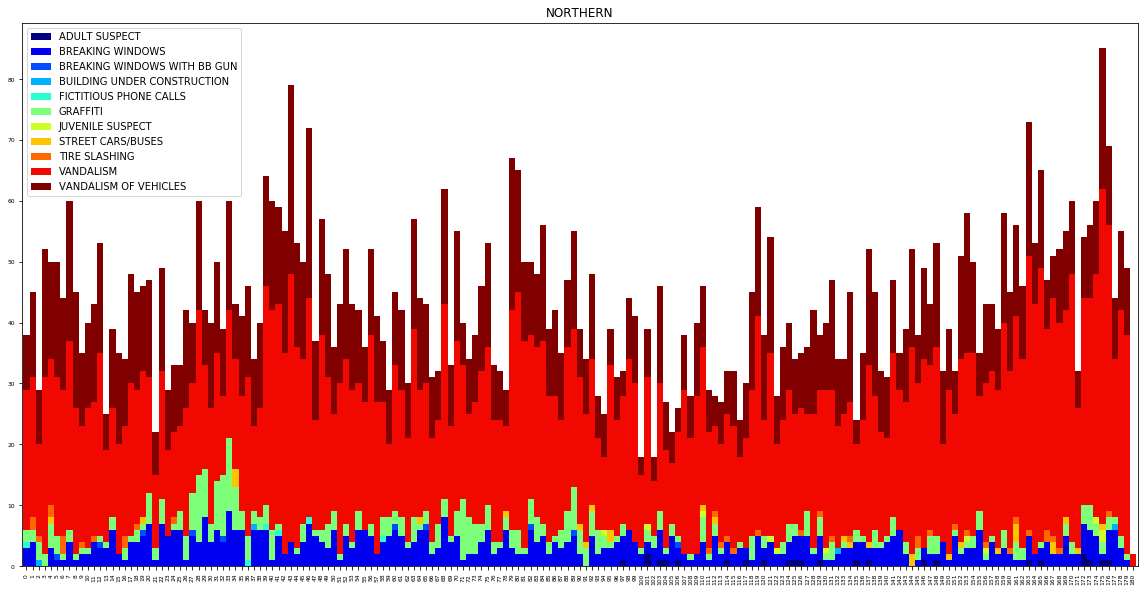

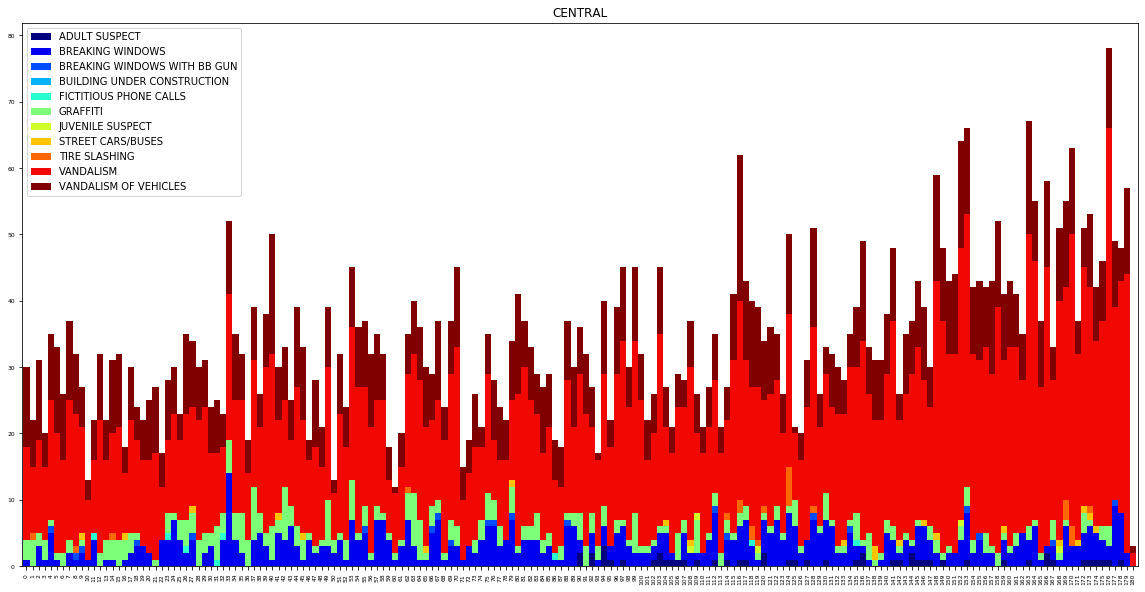

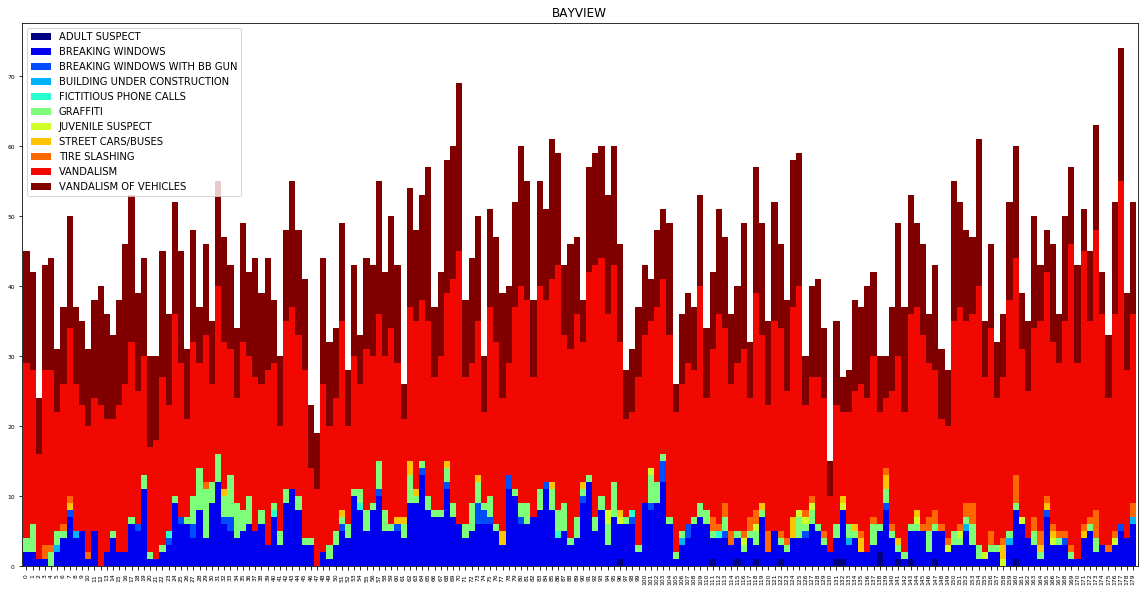

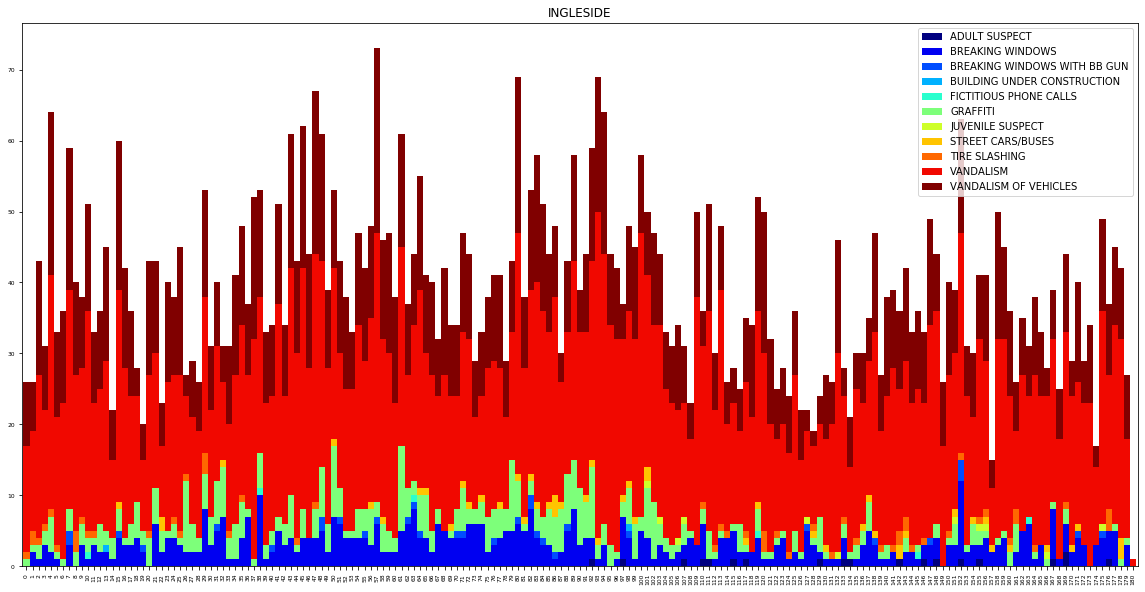

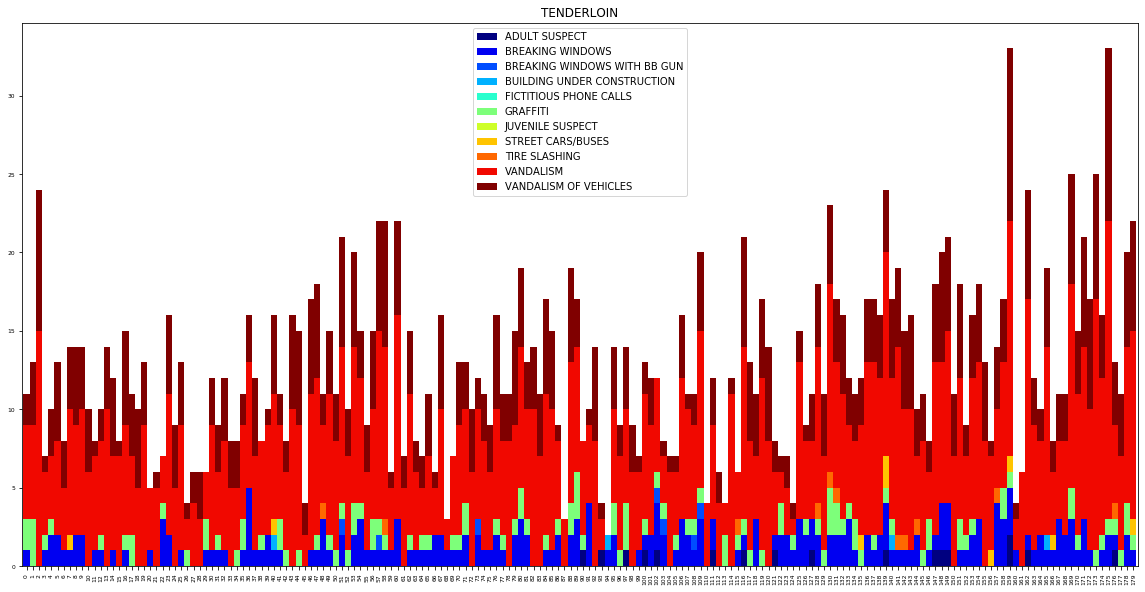

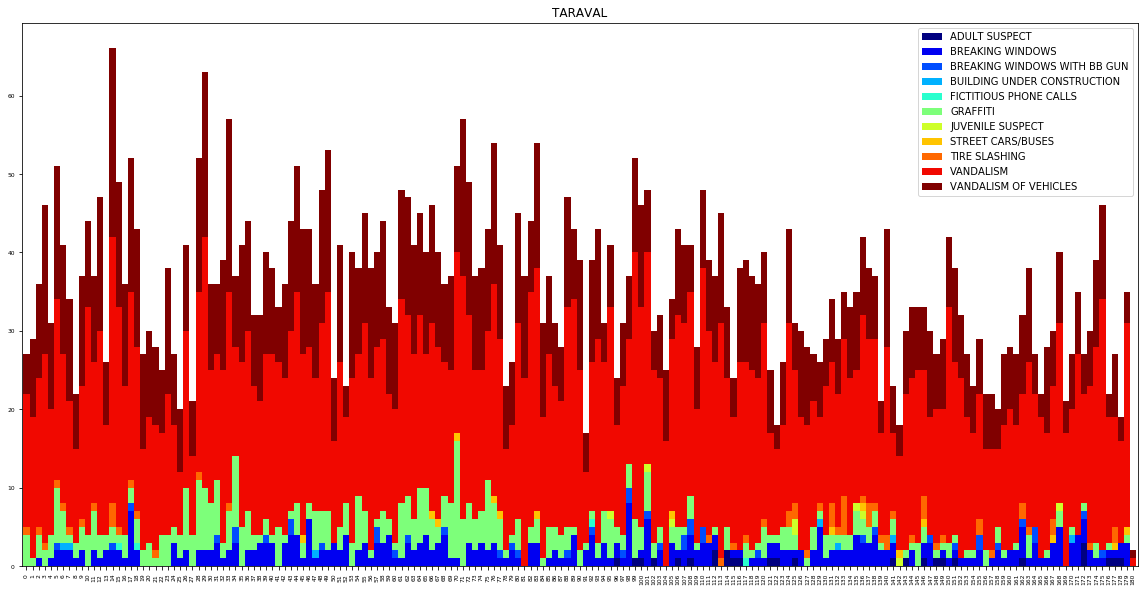

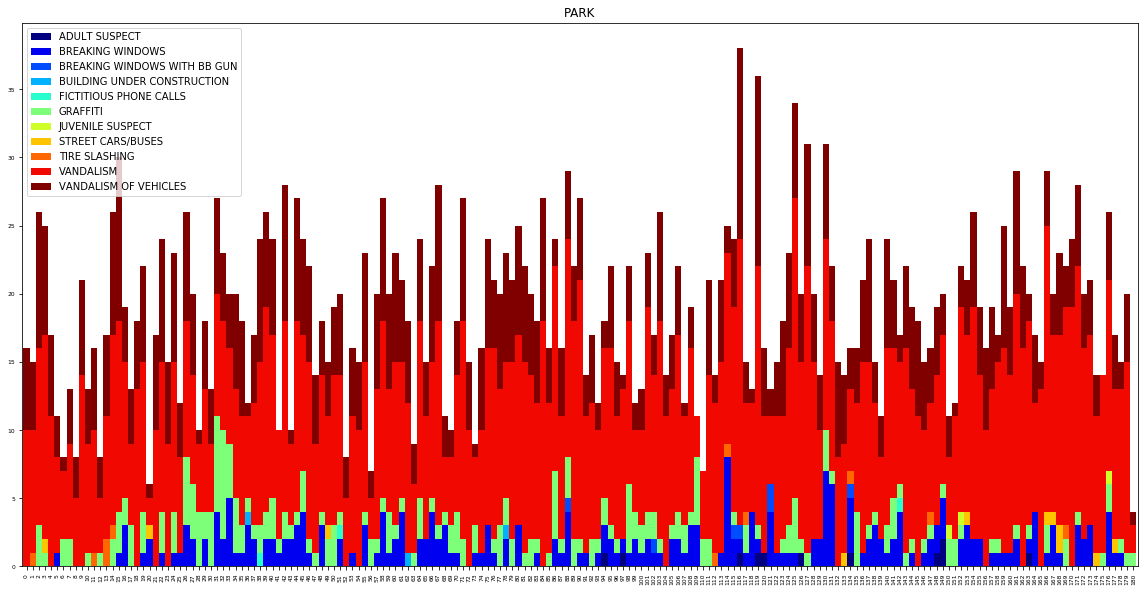

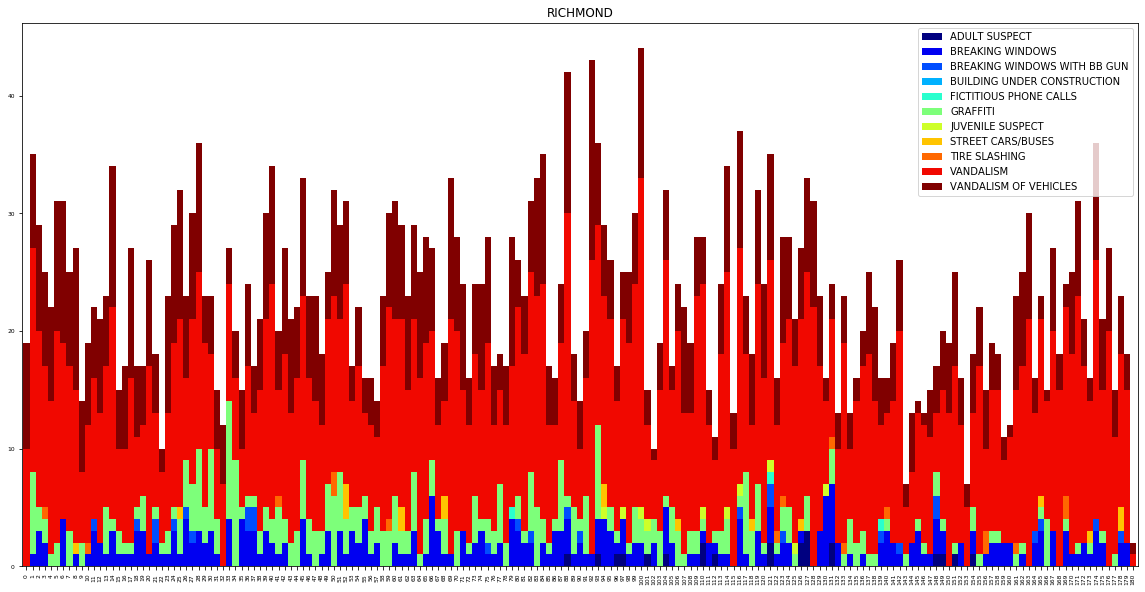

In [56]:
#Group by the vandalism by districts in the diferents graph
stor=[]
stor_time=[]

for d in d_crime['PdDistrict'].value_counts().index:
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,11)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    vanda_df=vandalism_analysis(m,d,True)
    plt.show()
    s=vanda_df.sum(axis=0)
    stor=stor+[s]
    vanda_df.columns=cols=[c+"_%s"%d for c in vanda_df.columns]
    stor_time=stor_time+[vanda_df]
    
vanda_dat_time=pd.concat(stor_time,axis=1)
vanda_dat=pd.concat(stor,axis=1)
vanda_dat.columns=[d_crime['PdDistrict'].value_counts().index]


## Let's perform Correlation Analysis

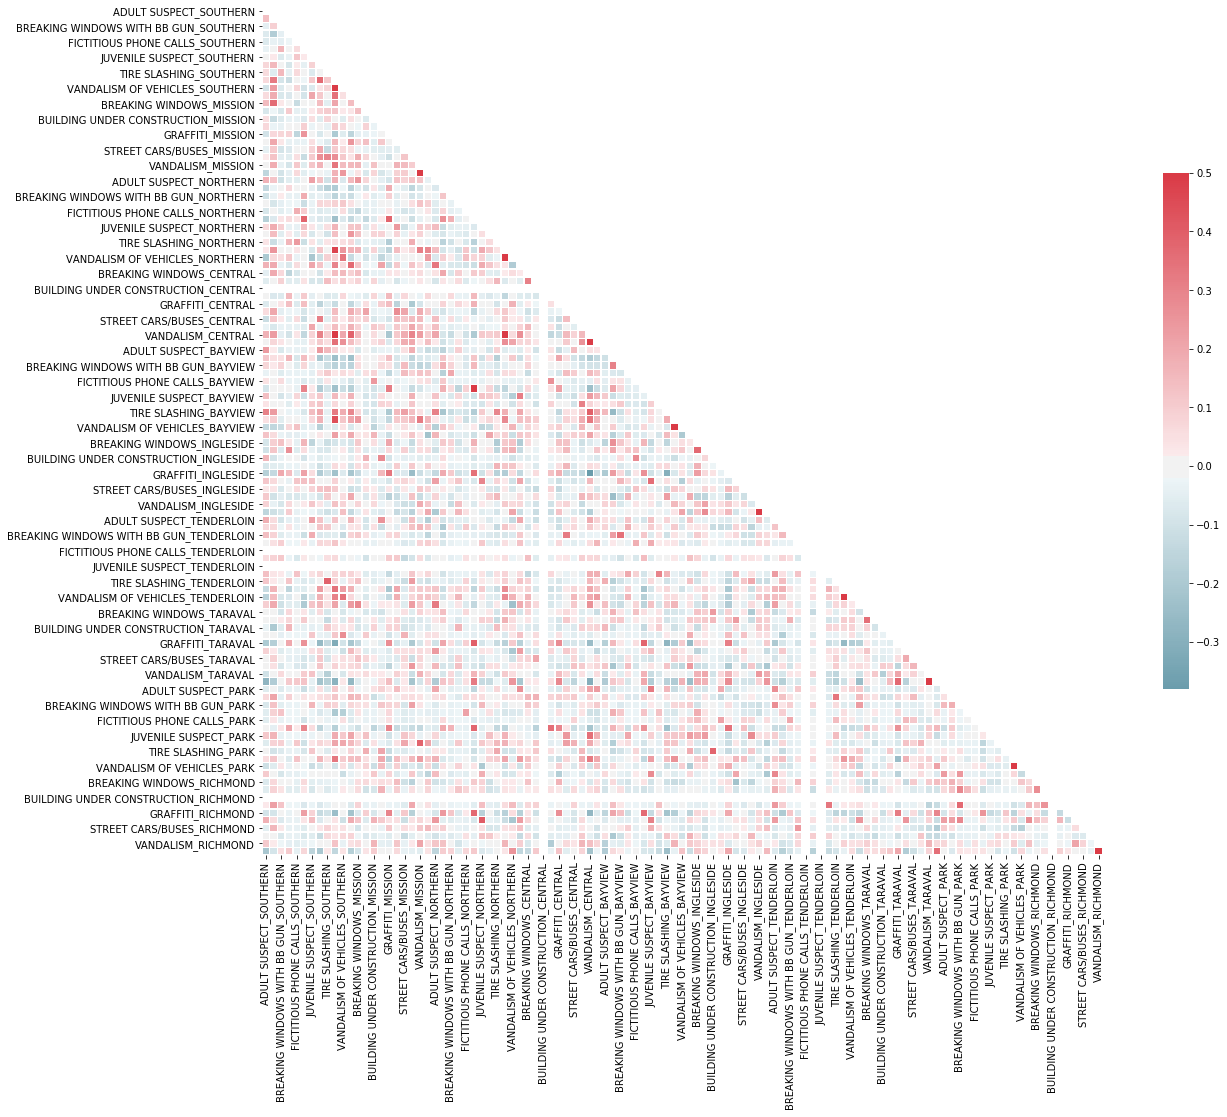

In [57]:
##We can also look at correlations between areas for different types vandalism.

sns.set_context(rc={"figure.figsize": (20,20)})
corr = vanda_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
sns.set_context(rc={"figure.figsize": (20,20)})
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(corr,  mask=mask, cmap=cmap, vmax=0.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

### Correlation Analysis

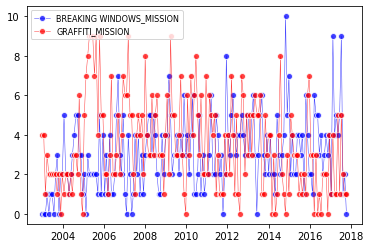

In [58]:
#With this in mind, we can examine select timeseries data.
vanda_dat_time.index=dates_for_plot.head(181)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['BREAKING WINDOWS_MISSION','GRAFFITI_MISSION'],['b','r']):
    plt.plot(vanda_dat_time.index,vanda_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

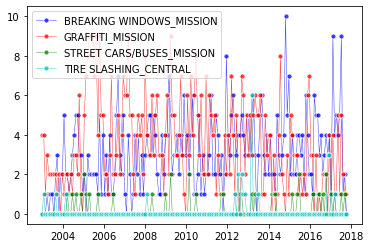

In [59]:
vanda_dat_time.index=dates_for_plot.head(181)
sns.set_context(rc={"figure.figsize": (30,15)})
for d,c in zip(['BREAKING WINDOWS_MISSION','GRAFFITI_MISSION','STREET CARS/BUSES_MISSION','TIRE SLASHING_CENTRAL'],['b','r','g','c']):
    plt.plot(vanda_dat_time.index,vanda_dat_time[d],'o-',color=c,ms=5,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':10})

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## San Francisco Incidents: Analysis by neighborhood

### Now we examine SPATIAL Relationships (Advance)

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

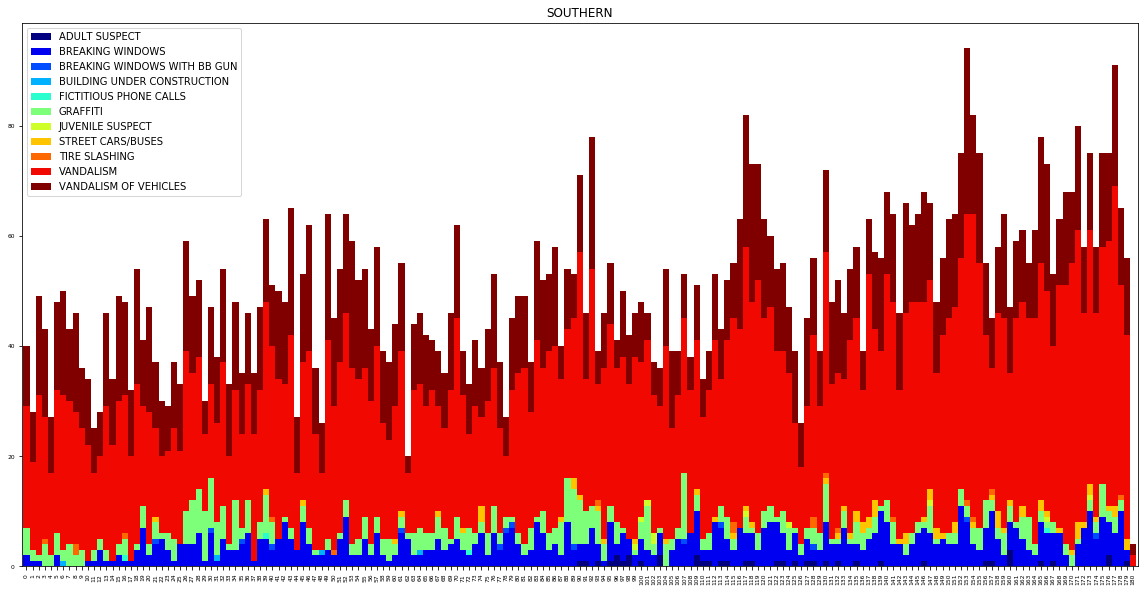

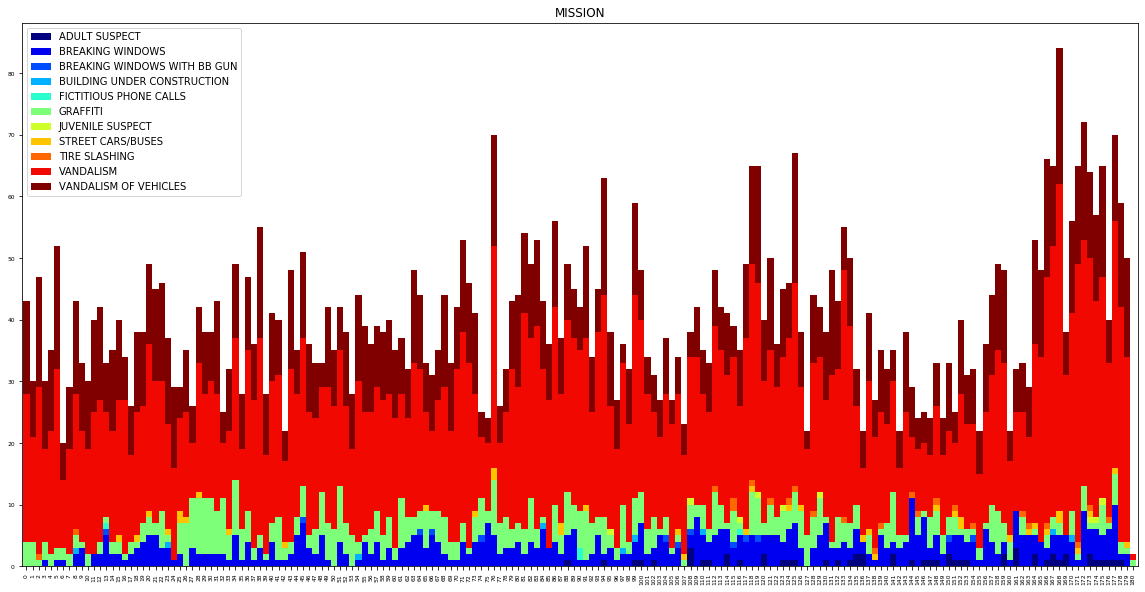

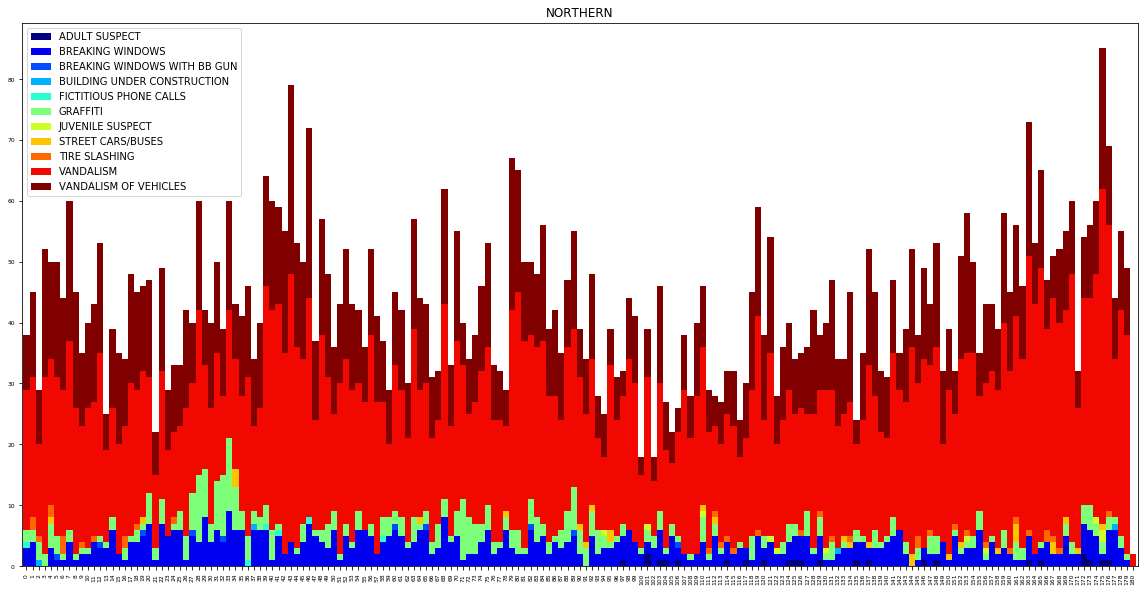

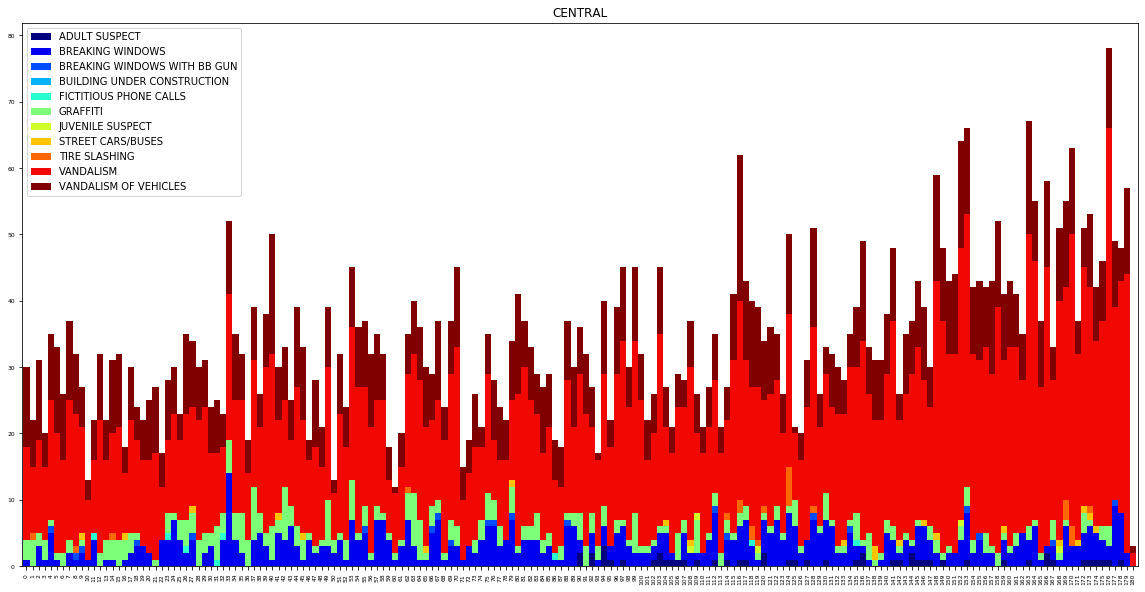

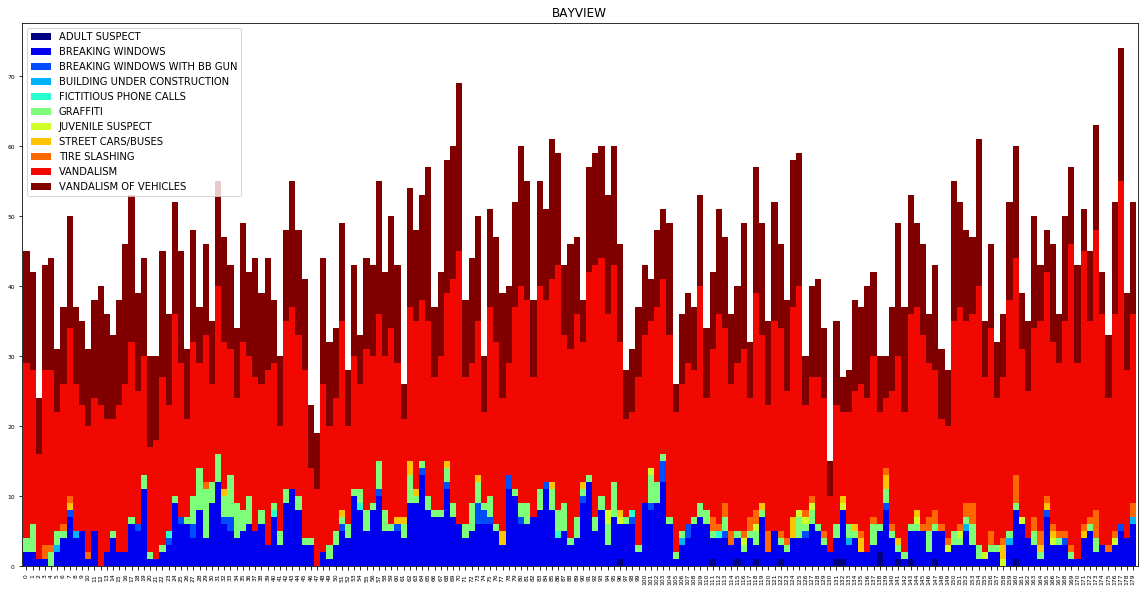

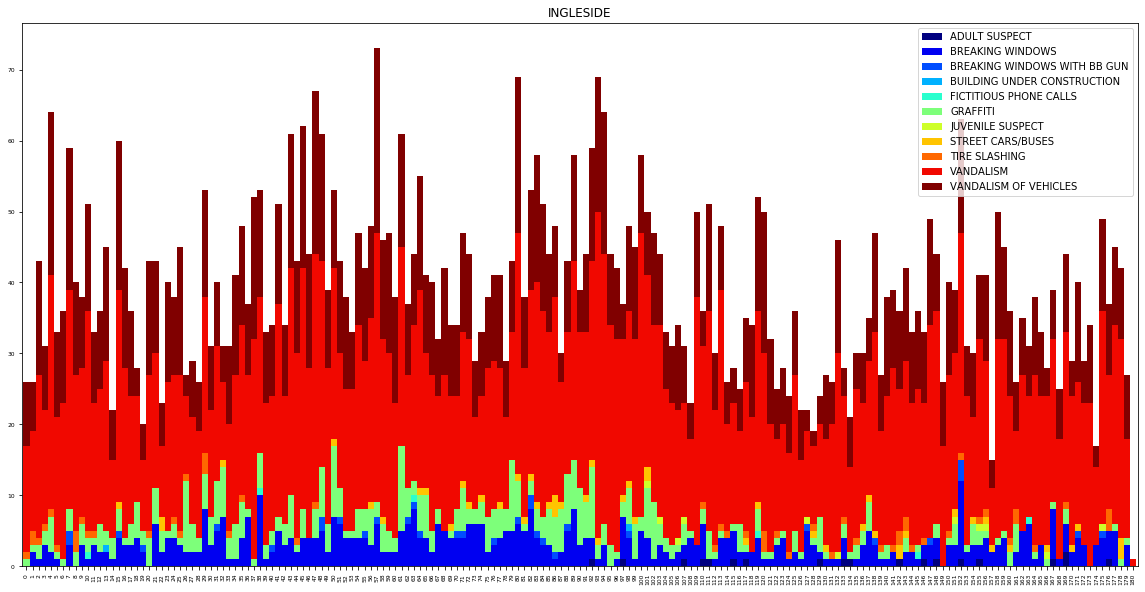

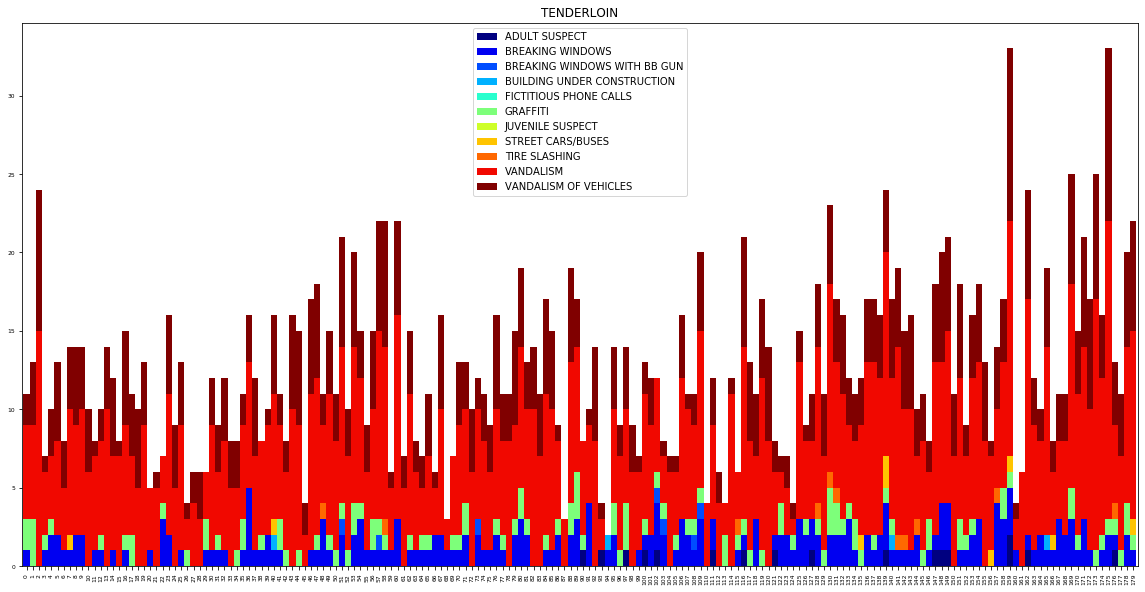

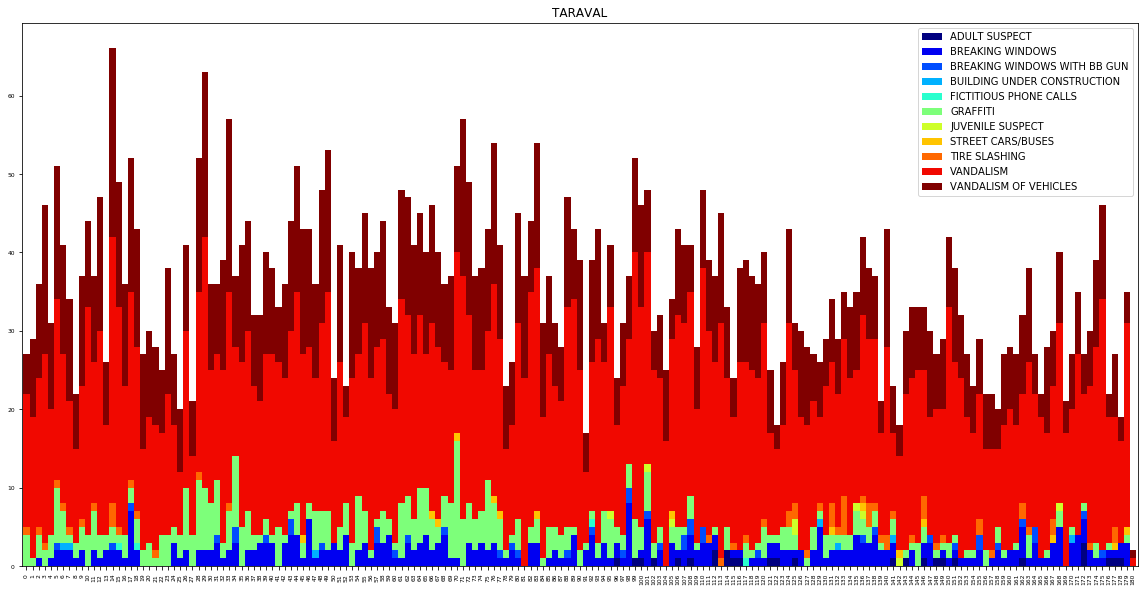

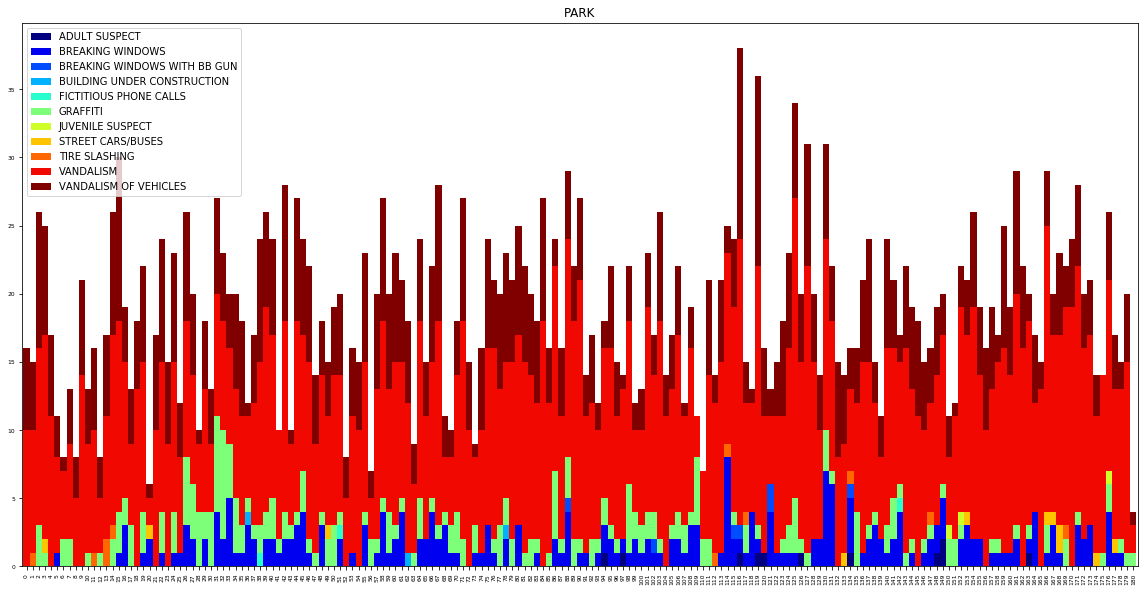

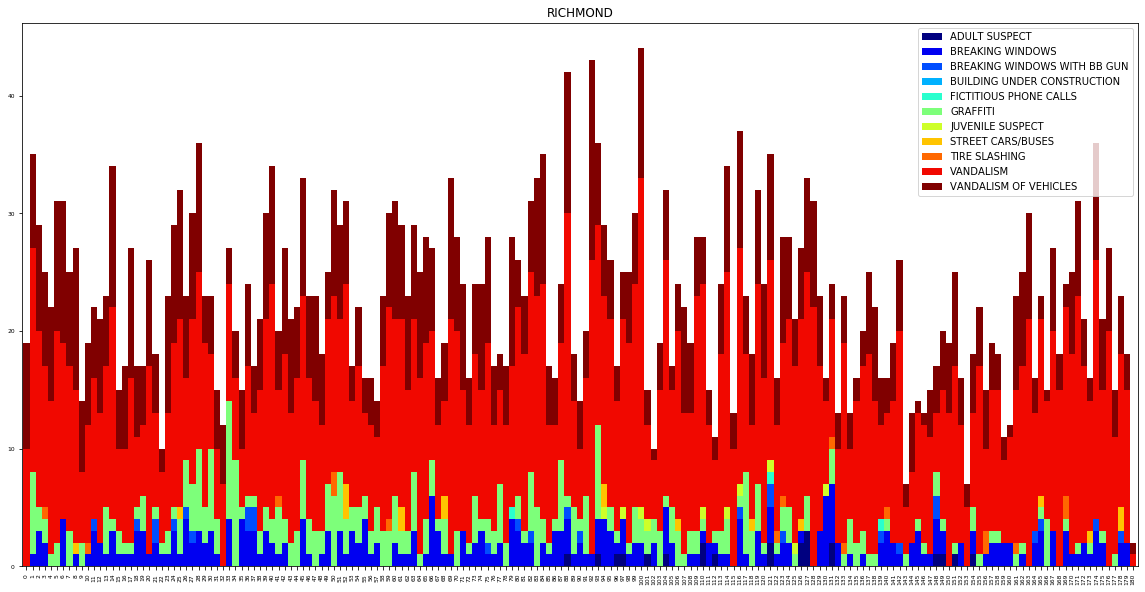

In [60]:
# We will analyze more in deep. Splitting data by district

stor=[]
stor_time=[]


for d in d_crime['PdDistrict'].value_counts().index:

    # Specify district and group by time
        dist_dat=df2[df2['PdDistrict']==d]
        t=timeseries(dist_dat,10)
        
        # Merge to ensure all categories are preserved!
        t_merge=pd.DataFrame(columns=t_all.columns)
        m=pd.concat([t_merge,t],axis=0).fillna(0)
        m.reset_index(inplace=True)

        # Plot
        vanda_df=vandalism_analysis(m,d,True)
        plt.show()
        s=vanda_df.sum(axis=0)
        stor=stor+[s]
        vanda_df.columns=cols=[c+"_%s"%d for c in vanda_df.columns]
        stor_time=stor_time+[vanda_df]

    

vanda_dat_time=pd.concat(stor_time,axis=1)
vanda_dat=pd.concat(stor,axis=1)
vanda_dat.columns=[d_crime['PdDistrict'].value_counts().index]

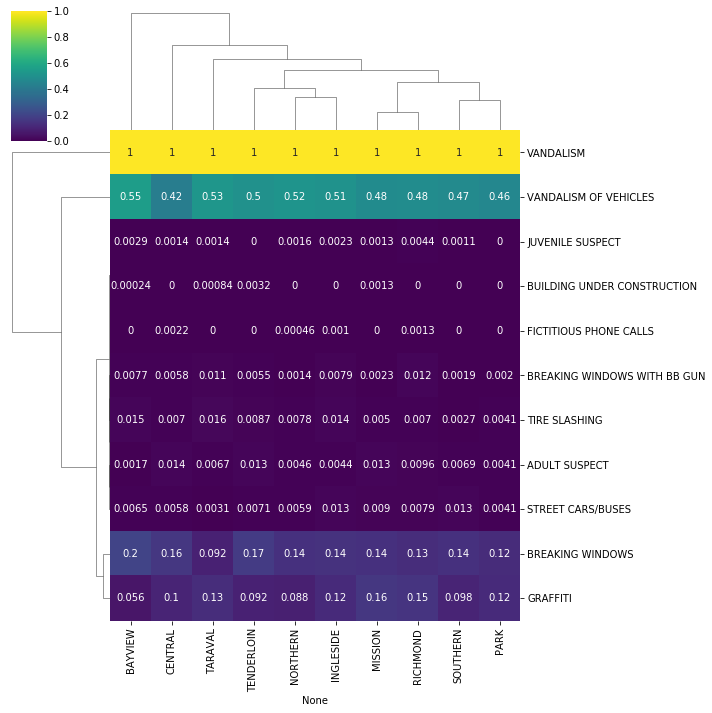

In [61]:
#We can now summarize this data using clustered heatmaps.
sns.clustermap(vanda_dat,standard_scale=1,cmap="viridis",robust=True,annot=True)

### Mapping relationships

In [62]:
#Let's isolate all vandalism-related records.

tmp=df2.copy()
tmp.set_index('Descript',inplace=True)

vandalism_dat=tmp.loc[vandalism_features]
vandalism_pts=vandalism_dat[['X','Y','Month']]

In [63]:
print(vandalism_pts)

                                          X          Y  Month
Descript                                                     
MALICIOUS MISCHIEF, VANDALISM   -122.390094  37.790764   52.0
MALICIOUS MISCHIEF, VANDALISM   -122.453775  37.766214   37.0
MALICIOUS MISCHIEF, VANDALISM   -122.408647  37.798117  130.0
MALICIOUS MISCHIEF, VANDALISM   -122.399680  37.749485  128.0
MALICIOUS MISCHIEF, VANDALISM   -122.387070  37.754790  169.0
...                                     ...        ...    ...
VANDALISM WITH NOXIOUS CHEMICAL -122.431046  37.783030  148.0
VANDALISM WITH NOXIOUS CHEMICAL -122.414167  37.808420  158.0
VANDALISM WITH NOXIOUS CHEMICAL -122.405728  37.751811   97.0
VANDALISM WITH NOXIOUS CHEMICAL -122.416269  37.752374  133.0
VANDALISM WITH NOXIOUS CHEMICAL -122.402836  37.786801  133.0

[34406 rows x 3 columns]


In [64]:
#Plot the suspect regimes.

d=pd.DataFrame(vandalism_pts.groupby('Month').size())
d.index=dates_for_plot.head(181)
d.columns=['Count']

diff=len(d.index)-120

In [65]:
print(diff)

61


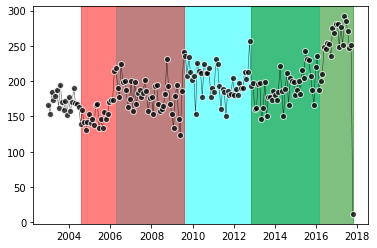

In [66]:
plt.plot(d.index,d['Count'],'o-',color='k',ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.axvspan(d.index[40-diff],d.index[40],color='cyan',alpha=0.5)
plt.axvspan(d.index[80-diff],d.index[80],color='red',alpha=0.5)
plt.axvspan(d.index[120],d.index[-1],color='green',alpha=0.5)

In [67]:
oldest_vandalism_sums=d.loc[(d.index>d.index[40-diff]) & (d.index<d.index[40])]
old_vandalism_sums=d.loc[(d.index>d.index[80-diff]) & (d.index<d.index[80])]
new_vandalism_sums=d.loc[d.index>d.index[120]]

In [68]:
#Fold-difference in mean between the two regimes.
old_vandalism_sums['Count'].mean()/float(new_vandalism_sums['Count'].mean())

0.8205066730600176

In [69]:
#Two regimes.

oldest_vandalism=vandalism_pts[(vandalism_pts['Month']>(40-diff)) & (vandalism_pts['Month']<40)]
oldest_vandalism.columns=['longitude','latitude','time']
old_vandalism=vandalism_pts[(vandalism_pts['Month']>(80-diff)) & (vandalism_pts['Month']<80)]
old_vandalism.columns=['longitude','latitude','time']
new_vandalism=vandalism_pts[vandalism_pts['Month']>120]
new_vandalism.columns=['longitude','latitude','time']

## We can look at this spatially.
##### Use a shapefile for Neighborhoods in SF to overlay the data onto a map.
##### https://data.sfgov.org/Geographic-Locations-and-Boundaries/Neighborhoods/ejmn-jyk6
##### Basemap can be used to view this. Some nice work at this link that I drew from:
##### http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html

In [70]:
# Let's create MongoBD collections to manage and query data
col1 = db.vandalismn
col2 = db.vandalismo
#Import data into the database
col1.drop()
col2.drop()

In [71]:
# Collection for new suspect
data_json1 = json.loads(new_vandalism.to_json(orient='records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [72]:
# Collection for old suspect
data_json2 = json.loads(old_vandalism.to_json(orient='records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [73]:
#Check if you can access the data from the MongoDB.
cursor = col1.find().sort('time',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e8b0f98072ad8792d15626c'), 'longitude': -122.447517051, 'latitude': 37.7785062672, 'time': 121.0}
{'_id': ObjectId('5e8b0f98072ad8792d156271'), 'longitude': -122.4367758383, 'latitude': 37.8006947037, 'time': 121.0}
{'_id': ObjectId('5e8b0f98072ad8792d1562c7'), 'longitude': -122.4538080326, 'latitude': 37.7849967238, 'time': 121.0}


In [74]:
cursor2 = col2.find().sort('time',pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('5e8b0f9a072ad8792d159326'), 'longitude': -122.4299509241, 'latitude': 37.7860338859, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1593a7'), 'longitude': -122.4064351682, 'latitude': 37.7638842089, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1593f1'), 'longitude': -122.3958916022, 'latitude': 37.7572374684, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d159420'), 'longitude': -122.4193501732, 'latitude': 37.7610160912, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1594bd'), 'longitude': -122.4035247952, 'latitude': 37.7544534412, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1594ed'), 'longitude': -122.4767584839, 'latitude': 37.7171079238, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1595d1'), 'longitude': -122.4009229558, 'latitude': 37.789760182, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d1595db'), 'longitude': -122.4164720354, 'latitude': 37.7603453746, 'time': 20.0}
{'_id': ObjectId('5e8b0f9a072ad8792d159613'), 'longitude': -122.4

In [75]:
# Create a new collection to store districts geo points
col3 = db.districts
col3.drop()

In [76]:
# mongoBD import from geojson file containing geopoints in form of multipopygons
os.system('"mongoimport" -d test -c districts --file \\Analysis_Neighborhoods.geojson')

0

In [77]:
cursor3 = col3.find().limit(10)
#for doc in cursor3:
    #print(doc)
    
# I commented the loop because Github show every row (there are so much rows :D )

In [78]:
# Get information about the index
col2.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'test.vandalismo'}}

### Prepare data to perform spatial queries by Mongo

In [79]:
col_temp = db.vandalismn2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [80]:
cursor = col_temp.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e8af1293124c68eb7e93d0b'), 'loc': {'type': 'Point', 'coordinates': [-122.3900942482, 37.7907638589]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d0c'), 'loc': {'type': 'Point', 'coordinates': [-122.4537748567, 37.7662135348]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d0d'), 'loc': {'type': 'Point', 'coordinates': [-122.4039801324, 37.7964121688]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d0e'), 'loc': {'type': 'Point', 'coordinates': [-122.3864376712, 37.7191834463]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d0f'), 'loc': {'type': 'Point', 'coordinates': [-122.4027426501, 37.7783990944]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d10'), 'loc': {'type': 'Point', 'coordinates': [-122.4033935014, 37.8046299931]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d11'), 'loc': {'type': 'Point', 'coordinates': [-122.4421951656, 37.7460301008]}}
{'_id': ObjectId('5e8af1293124c68eb7e93d12'), 'loc': {'type': 'Point', 'coordinates': [-122.4004194186, 37.7520752845]}}
{'_id': ObjectId('5e8af1293124c6

In [81]:
cursor2 = col2.find_one()   

In [82]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [83]:
cursor3 = col3.find_one(query)

In [84]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3["features"])

In [85]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [86]:
# Spatial query implementing getoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [87]:
# Have a look if every thing is OK

#for doc in collection_features.find(query_feat):
#    print(doc)

# I commented this as same before.(github show everything)

In [88]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

{'nhood': 'Financial District/South Beach'}


### Printing data in Maps

In [89]:
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45) ## San Francisco Coordinates

In [90]:
MAX_RECORDS = 100
m = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [91]:
#Display neighborhoods by polygons
geo_json_data = json.load(open('Analysis_Neighborhoods.geojson'))
folium.GeoJson(geo_json_data).add_to(m)

In [92]:
# Display Old VANDALISM points (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='Old Vandalism',
                  icon=folium.Icon(color='red')).add_to(m)

In [93]:
# Display New VANDALISM Points (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='New Vandalism',
                  icon=folium.Icon(color='green')).add_to(m)

In [94]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(m)

In [95]:
folium.LayerControl().add_to(m)

In [96]:
m.save(outfile='map1.html')

In [97]:
#Map with the location of the vandalism
m

In [98]:
# Obtaining the geometry of an Incident

In [99]:
map2 = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [100]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

In [101]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map2)

In [102]:
folium.LayerControl().add_to(map2)

In [103]:
map2.save(outfile='map2.html')

In [104]:
map2

### To detect every vandalism (new and old) in a especific district:

In [105]:
query_hood = {"loc": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "MultiPolygon", 
                     "coordinates": cursor_feat["geometry"]["coordinates"]
                    }
                }
            }
        }

In [106]:
col_temp = db.vandalismn2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [107]:
cursor = col_temp.find()
col_temp2 = db.vandalismo2
cursor = col1.find()
for doc in cursor:
    col_temp2.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });


In [108]:
map3 = folium.Map(location=SF_COORDINATES, zoom_start=12)

folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map3)


In [109]:
cursor_p = col_temp.find(query_hood).limit(70)

for doc in cursor_p:
    folium.Marker(location = [doc["loc"]["coordinates"][1],doc["loc"]["coordinates"][0]],
                  popup='New Vandalism',
                  icon=folium.Icon(color='green')).add_to(map3)

In [110]:
cursor_p2 = col_temp2.find(query_hood).limit(70)

for doc in cursor_p2:
    folium.Marker(location = [doc["loc"]["coordinates"][1],doc["loc"]["coordinates"][0]],
                  popup='Old Vandalism',
                  icon=folium.Icon(color='red')).add_to(map3)

In [111]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],

                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map3)

folium.LayerControl().add_to(map3)
map3.save(outfile='map3.html')

In [112]:
map3